# **Task 1: Hyperspectral Land Type Classification**

### **Introduction & Roadmap**

We tackle the classification of alpine vegetation types using hyperspectral satellite imagery from Austria's Tyrol region. Our dataset contains 215,604 pixel observations across 8 land types, with each pixel characterized by 218 spectral bands spanning 420-2450 nm wavelengths.

### **Our Approach**

**Data Preparation:**
- We created a stratified sample of 50,001 observations to balance computational efficiency with statistical robustness
- We maintained class proportions from the original dataset across all land types
- We split data into 80% training (40,000 samples) and 20% test (10,001 samples) with stratification

**Classification Strategy:**
We evaluated 7 different classifiers using two distinct approaches:
- **Full Feature Approach:** Training on all 218 original spectral bands
- **Dimensionality Reduction Approach:** Training on 10 principal components (capturing 99.9% of variance)

**Models Evaluated:**
- Linear Discriminant Analysis (LDA)
- Quadratic Discriminant Analysis (QDA)
- k-Nearest Neighbors (k-NN)
- Logistic Regression with L2 regularization
- Support Vector Machine (SVM) with RBF kernel
- Random Forest (bagging ensemble)
- Gradient Boosting Decision Trees (GBDT - boosting ensemble)

**Specialized Analysis:**
We also reframed the problem as binary classification (glacier ice vs. all other types) to address glacier detection. Given that snow/ice represents only 5.35% of observations, we optimized for F1 score to handle this severe class imbalance.

---

*What follows is our complete analysis pipeline from exploratory data analysis through model evaluation and specialized glacier detection.*

### **Importing all necessary libraries**

- The basic python libraries 
- A range of visualisation libraries
- Preprocessing libraries for tasks such as scaling and PCA
- The libraries for the 7 models we use 
- The evaluation metrics 

In [2]:
# The core python libraries
import pandas as pd
import numpy as np

# Key visualisation libraries for exploring our data and visualising results
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
import plotly.graph_objects as go
#import missingno as msno 

# We use a range of preprocessing techniques to ensure our data is ready for modelling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# We use 7 models in this part, and import each of them from scikit-learn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


# The libraries we need to then evaluate the models 
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

### **Exploratory Data Analysis**

In [3]:
df = pd.read_csv("../data/raw/data-1.csv")
df.head()

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex
0,valley floor / meadow,0,0,0.0174,0.0131,0.0108,0.0133,0.0158,0.0144,0.0151,...,0.0237,0.0231,0.0224,0.0246,0.0255,0.0174,0.0234,0.0147,#030B05,#25C77140
1,valley floor / meadow,1,0,0.0180,0.0124,0.0116,0.0143,0.0154,0.0136,0.0151,...,0.0289,0.0275,0.0288,0.0293,0.0286,0.0211,0.0229,0.0176,#040A09,#25C77140
2,valley floor / meadow,2,0,0.0151,0.0150,0.0113,0.0158,0.0167,0.0158,0.0163,...,0.0358,0.0319,0.0355,0.0274,0.0303,0.0232,0.0282,0.0181,#08110B,#25C77140
3,valley floor / meadow,3,0,0.0172,0.0149,0.0095,0.0156,0.0154,0.0169,0.0176,...,0.0310,0.0294,0.0307,0.0238,0.0304,0.0232,0.0247,0.0087,#0C160C,#25C77140
4,valley floor / meadow,4,0,0.0184,0.0149,0.0143,0.0189,0.0174,0.0174,0.0182,...,0.0428,0.0372,0.0407,0.0344,0.0415,0.0287,0.0317,0.0176,#0E180C,#25C77140


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215604 entries, 0 to 215603
Columns: 223 entries, land_type to overlay_hex
dtypes: float64(218), int64(2), object(3)
memory usage: 366.8+ MB


In [4]:
df.describe()

,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,Band_8,...,Band_209,Band_210,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218
count,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,...,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000,215604.000000
mean,176.934871,303.167789,0.095601,0.094335,0.095621,0.099081,0.100492,0.101252,0.102764,0.104476,...,0.110929,0.108438,0.108563,0.105381,0.105773,0.100424,0.099806,0.095834,0.092850,0.086839
std,102.491875,175.323061,0.164291,0.163833,0.165067,0.166807,0.167414,0.167216,0.167939,0.168141,...,0.059208,0.059431,0.059182,0.059277,0.058764,0.057765,0.056946,0.057251,0.054999,0.056024
min,0.000000,0.000000,-0.012000,-0.012600,-0.011900,-0.008800,-0.009300,-0.009000,-0.007700,-0.007500,...,0.007400,0.005700,0.006900,0.003600,0.006800,0.002400,0.004100,0.001100,0.000100,-0.010000
25%,88.000000,151.000000,0.022600,0.020600,0.020000,0.022900,0.023400,0.023800,0.024500,0.025500,...,0.058600,0.055700,0.056000,0.052500,0.053500,0.048900,0.048900,0.044400,0.043600,0.036300
50%,177.000000,303.000000,0.037800,0.036800,0.037700,0.040600,0.041600,0.042200,0.043400,0.045300,...,0.101100,0.098200,0.098200,0.094900,0.095000,0.089600,0.089000,0.085100,0.082300,0.076000
75%,266.000000,455.000000,0.078000,0.078000,0.081100,0.083800,0.086100,0.087700,0.090000,0.092700,...,0.157700,0.155500,0.155300,0.152500,0.152300,0.146400,0.145100,0.141500,0.136700,0.132000
max,354.000000,607.000000,1.581000,1.574100,1.587100,1.595900,1.603600,1.605300,1.609500,1.613800,...,0.453700,0.446600,0.453600,0.449000,0.446700,0.429900,0.435100,0.433000,0.429100,0.411200


In [29]:
# lets take a look at unique values for land_type
df["land_type"].unique()
df["land_type"].value_counts()

land_type
alpine meadow            50657
alpine tundra            38900
valley floor / meadow    38424
bare rock                26314
veg-scree mix            24495
scree / sunlit rock      15153
snow / ice               11533
dark rock                10128
Name: count, dtype: int64

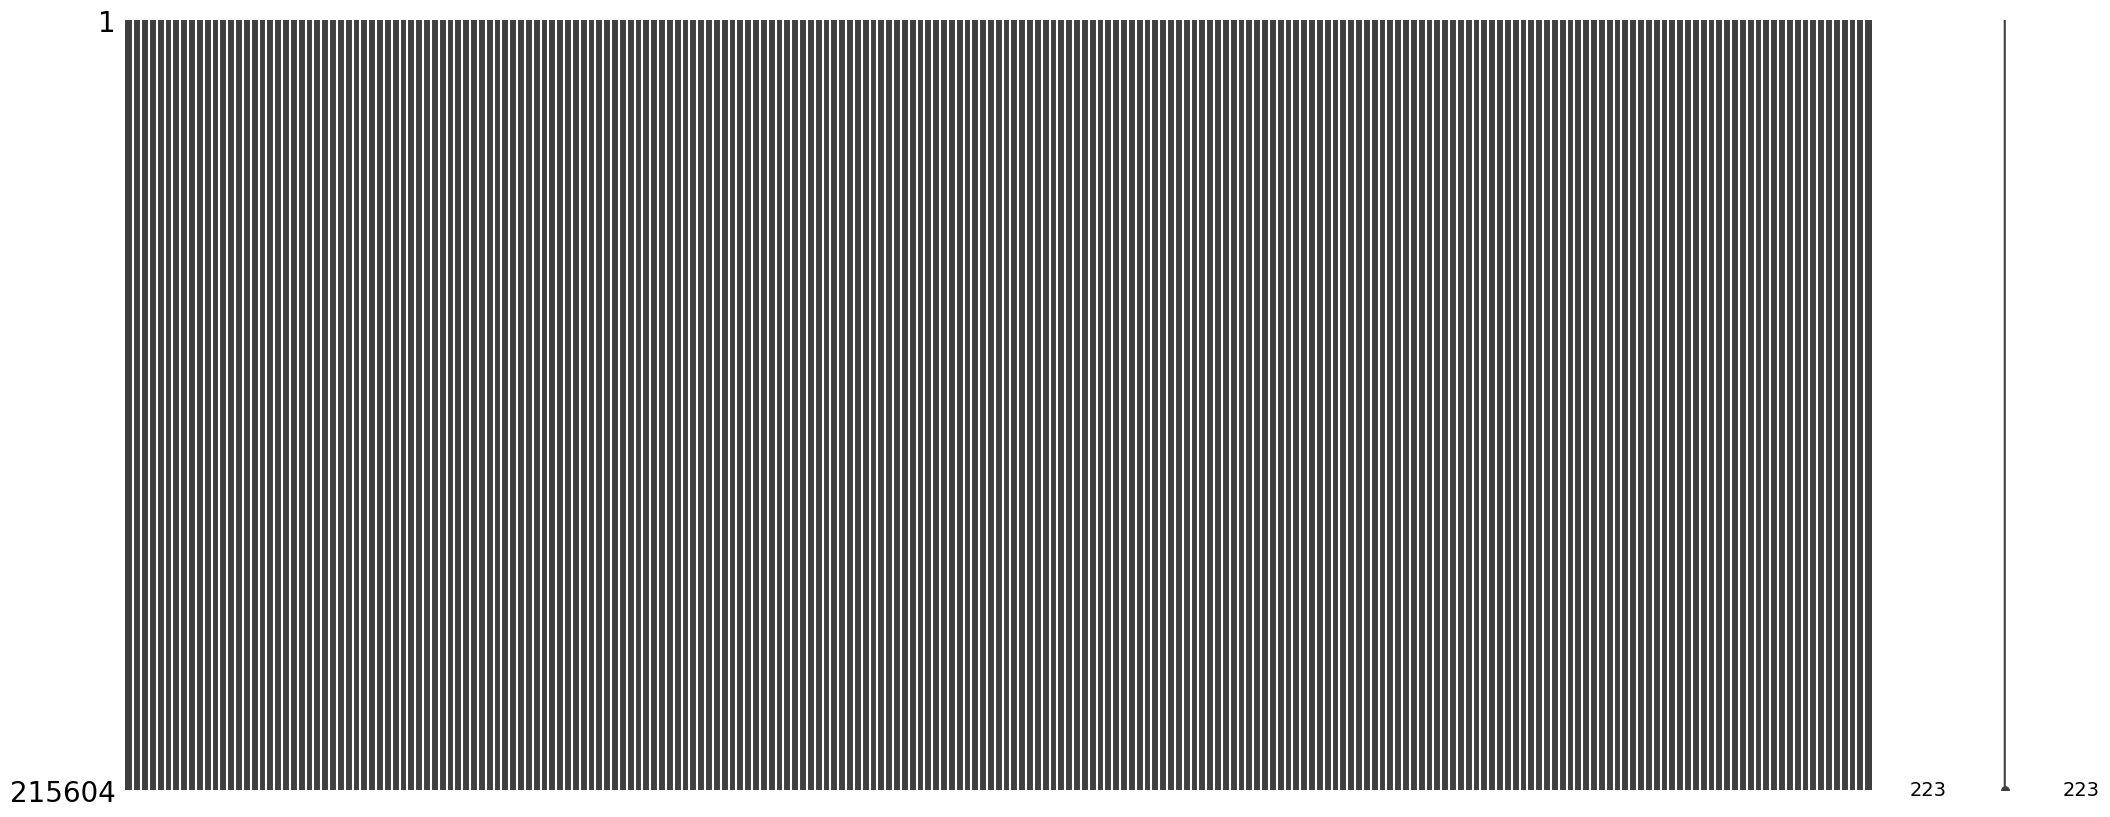

In [ ]:
# Visualizing missing data
msno.matrix(df)
plt.show()

#### Stratified Sampling a subset of 50000 samples

In [4]:
# Stratified sampling the RIGHT way:
sample_size = 50000
sample_fraction = sample_size / len(df)

df_sample = df.groupby('land_type', group_keys=False).apply(
    lambda x: x.sample(frac=sample_fraction, random_state=42)
)

In [32]:
df_sample.head()

,land_type,p_x,p_y,Band_1,Band_2,Band_3,Band_4,Band_5,Band_6,Band_7,...,Band_211,Band_212,Band_213,Band_214,Band_215,Band_216,Band_217,Band_218,rgb_hex,overlay_hex
15920,alpine meadow,300,44,0.0238,0.0214,0.0202,0.0223,0.0228,0.0231,0.0257,...,0.0616,0.0567,0.0573,0.0523,0.0508,0.0488,0.0473,0.0428,#1B1A13,#4B005540
91192,alpine meadow,312,256,0.0359,0.0361,0.0365,0.0399,0.0384,0.0388,0.0399,...,0.0930,0.0889,0.0897,0.0812,0.0814,0.0801,0.0748,0.0659,#2B2F21,#4B005540
108272,alpine meadow,352,304,0.0266,0.0248,0.0241,0.0257,0.0286,0.0278,0.0270,...,0.0709,0.0648,0.0663,0.0619,0.0586,0.0544,0.0528,0.0522,#1C1F15,#4B005540
189652,alpine meadow,82,534,0.0200,0.0181,0.0171,0.0198,0.0196,0.0202,0.0204,...,0.0465,0.0439,0.0427,0.0418,0.0400,0.0344,0.0368,0.0324,#0F0E0E,#4B005540
202127,alpine meadow,132,569,0.0410,0.0375,0.0364,0.0406,0.0419,0.0405,0.0427,...,0.0982,0.0917,0.0983,0.0924,0.0843,0.0749,0.0816,0.0724,#292E22,#4B005540


In [33]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50001 entries, 15920 to 197545
Columns: 223 entries, land_type to overlay_hex
dtypes: float64(218), int64(2), object(3)
memory usage: 85.5+ MB


In [13]:
# Save sample to data/raw folder
df_sample.to_csv('../data/raw/data_sample.csv', index=False)

In [5]:
df_sample_land_type = df_sample['land_type'].value_counts()
df_sample_land_type

alpine meadow            11748
alpine tundra             9021
valley floor / meadow     8911
bare rock                 6102
veg-scree mix             5681
scree / sunlit rock       3514
snow / ice                2675
dark rock                 2349
Name: land_type, dtype: int64

#### VIsualizing Sample Dataset

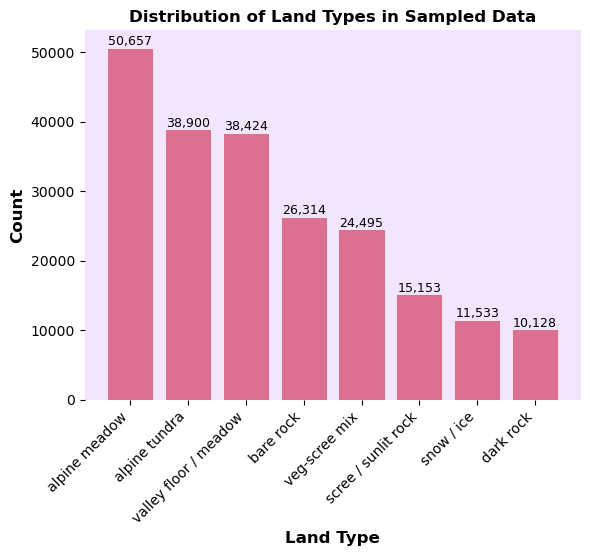

<Figure size 1000x800 with 0 Axes>

In [6]:
df_land_type = df['land_type'].value_counts()

bars = plt.bar(df_land_type.index, df_land_type.values, color='palevioletred', 
               edgecolor='white', linewidth=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{int(height):,}',
            ha='center', va='bottom', fontsize=9)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(False)
plt.gca().spines['bottom'].set_linewidth(False)
plt.gca().set_facecolor('#f2e6ff')
plt.title('Distribution of Land Types in Sampled Data', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Land Type', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')


plt.figure(figsize=(10,8))
plt.show()

In [ ]:
# Comparing real data and sample data compositions
perc_real = (df['land_type'].value_counts() / len(df)) * 100
perc_sample = (df_sample['land_type'].value_counts() / len(df_sample)) * 100

pd.DataFrame({
    'Real Data Percentage': perc_real,
    'Sampled Data Percentage': perc_sample
})

,Real Data Percentage,Sampled Data Percentage
land_type,,
alpine meadow,23.495390,23.495530
alpine tundra,18.042337,18.041639
valley floor / meadow,17.821562,17.821644
bare rock,12.204783,12.203756
veg-scree mix,11.361106,11.361773
scree / sunlit rock,7.028163,7.027859
snow / ice,5.349159,5.349893
dark rock,4.697501,4.697906


#### Visualizing the mean reflectance of each land type

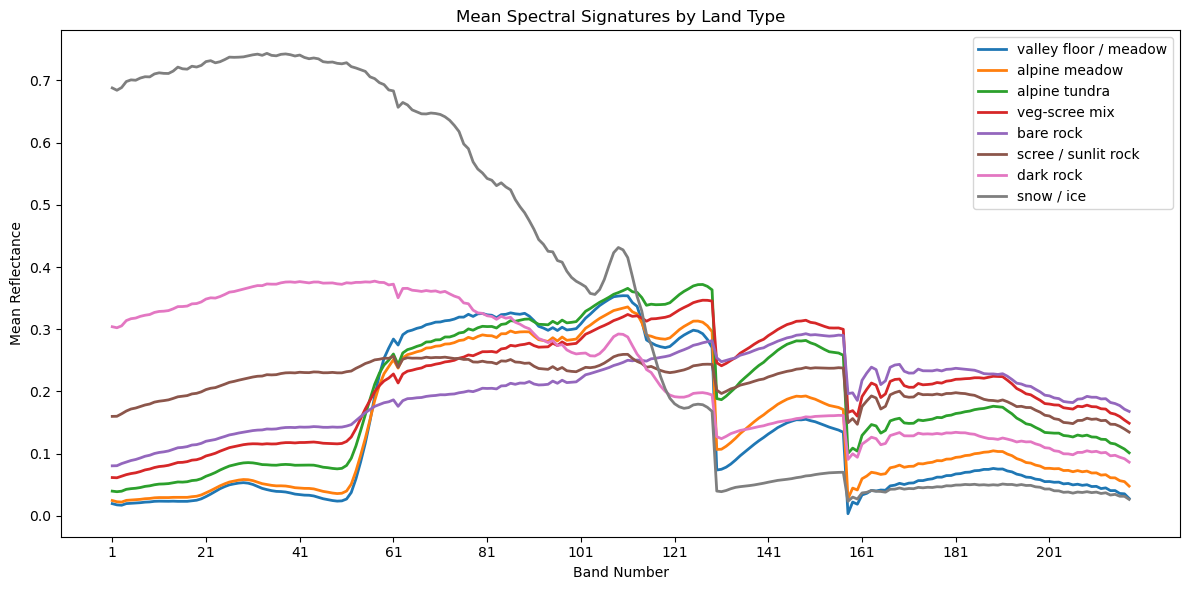

In [7]:
# Get the band columns
band_columns = [f'Band_{i}' for i in range(1, 219)]

# Create the plot
plt.figure(figsize=(12, 6))

# For each land type, calculate and plot the mean reflectance
for land_type in df['land_type'].unique():
    # Get rows for this land type
    land_data = df[df['land_type'] == land_type]
    
    # Calculate mean reflectance for each band
    mean_reflectance = land_data[band_columns].mean()
    
    # Plot it
    plt.plot(mean_reflectance, label=land_type, linewidth=2)

# Add labels and legend
plt.xticks(ticks=np.arange(0, 219, 20), labels=np.arange(1, 218, 20))
plt.xlabel('Band Number')
plt.ylabel('Mean Reflectance')
plt.title('Mean Spectral Signatures by Land Type')
plt.legend()
plt.tight_layout()
plt.show()

#### Scatter plot of land types

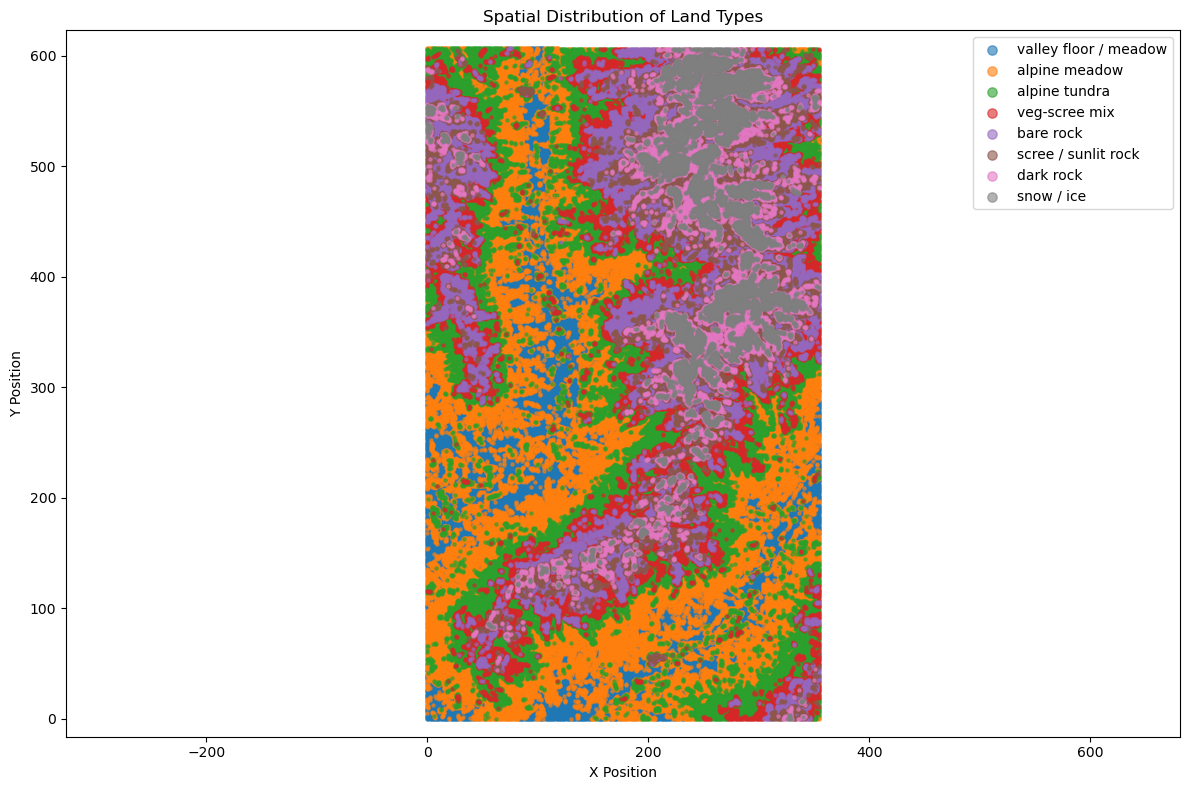

In [8]:
plt.figure(figsize=(12, 8))

# Plot each land type with different color
for land_type in df['land_type'].unique():
    land_data = df[df['land_type'] == land_type]
    plt.scatter(land_data['p_x'], land_data['p_y'], 
                label=land_type, alpha=0.6, s=5)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Spatial Distribution of Land Types')
plt.legend(markerscale=3)
plt.axis('equal')  # Makes x and y scales the same
plt.tight_layout()
plt.show()

### **Encoding Target**

- Convert categorical land_type labels into numerical values (0-7)

- LabelEncoder assigns a unique integer to each vegetation class

- Save mapping so we can interpret results later
- Keep original 'land_type' column for reference during EDA

In [5]:
# Create label encoder
le = LabelEncoder()

# Encode land_type to numerical values
df_sample['land_type_encoded'] = le.fit_transform(df_sample['land_type'])

# Check mapping
print("Class mapping:")
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")
    
print(f"\nOriginal: {df_sample['land_type'].head()}")
print(f"Encoded: {df_sample['land_type_encoded'].head()}")

Class mapping:
0: alpine meadow
1: alpine tundra
2: bare rock
3: dark rock
4: scree / sunlit rock
5: snow / ice
6: valley floor / meadow
7: veg-scree mix

Original: 15920     alpine meadow
91192     alpine meadow
108272    alpine meadow
189652    alpine meadow
202127    alpine meadow
Name: land_type, dtype: object
Encoded: 15920     0
91192     0
108272    0
189652    0
202127    0
Name: land_type_encoded, dtype: int32


In [6]:
# Select only the spectral bands as features
band_columns = [f'Band_{i}' for i in range(1, 219)]  # Band_1 to Band_218
X = df_sample[band_columns]

# Set target variable
y = df_sample['land_type_encoded']

# Check dimensions
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFirst few features:\n{X.head()}")

Feature matrix shape: (50001, 218)
Target vector shape: (50001,)

First few features:
        Band_1  Band_2  Band_3  Band_4  Band_5  Band_6  Band_7  Band_8  \
15920   0.0238  0.0214  0.0202  0.0223  0.0228  0.0231  0.0257  0.0248   
91192   0.0359  0.0361  0.0365  0.0399  0.0384  0.0388  0.0399  0.0421   
108272  0.0266  0.0248  0.0241  0.0257  0.0286  0.0278  0.0270  0.0285   
189652  0.0200  0.0181  0.0171  0.0198  0.0196  0.0202  0.0204  0.0215   
202127  0.0410  0.0375  0.0364  0.0406  0.0419  0.0405  0.0427  0.0435   

        Band_9  Band_10  ...  Band_209  Band_210  Band_211  Band_212  \
15920   0.0255   0.0261  ...    0.0610    0.0577    0.0616    0.0567   
91192   0.0419   0.0428  ...    0.0952    0.0957    0.0930    0.0889   
108272  0.0277   0.0294  ...    0.0728    0.0707    0.0709    0.0648   
189652  0.0207   0.0226  ...    0.0474    0.0439    0.0465    0.0439   
202127  0.0441   0.0465  ...    0.1103    0.0993    0.0982    0.0917   

        Band_213  Band_214  Band_215

### **Train-Test Split**

- We split our data into 80% training and 20% test sets to evaluate model performance

- We use stratified splitting to maintain the same class proportions in both train and test sets

- We set random_state=42 for reproducibility so our results are consistent

- We verify the split worked correctly and classes are balanced across both sets

In [ ]:


# Split data into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,  # Maintain class distribution
    random_state=42
)

# Check split sizes
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nClass distribution in train set:")
print(y_train.value_counts().sort_index())

Training set: (40000, 218)
Test set: (10001, 218)

Class distribution in train set:
land_type_encoded
0    9398
1    7217
2    4881
3    1879
4    2811
5    2140
6    7129
7    4545
Name: count, dtype: int64


- We standardize all 218 spectral bands to have mean=0 and std=1

- We fit the scaler only on training data to prevent data leakage from test set

- We apply the same transformation to test data using the training set's parameters

- Scaling is crucial for PCA since it's sensitive to feature magnitudes

In [8]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify scaling worked
print(f"Original training data - Mean: {X_train.mean().mean():.3f}, Std: {X_train.std().mean():.3f}")
print(f"Scaled training data - Mean: {X_train_scaled.mean():.3f}, Std: {X_train_scaled.std():.3f}")

Original training data - Mean: 0.190, Std: 0.104
Scaled training data - Mean: 0.000, Std: 1.000


### **Linear Discriminant Analysis**

In [ ]:

# Define hyperparameter grid (fixed - avoid invalid combinations)
param_grid_lda = [
    {'solver': ['svd']},  # SVD doesn't use shrinkage
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.5, 0.7]}
]

# GridSearchCV
lda_grid = GridSearchCV(
    LinearDiscriminantAnalysis(),
    param_grid_lda,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting LDA hyperparameter tuning...")
lda_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {lda_grid.best_params_}")
print(f"Best CV accuracy: {lda_grid.best_score_:.4f}")

Starting LDA hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters: {'shrinkage': 0.7, 'solver': 'lsqr'}
Best CV accuracy: 0.8683


### **Quadratic Discriminant Analysis**

In [ ]:

# Define hyperparameter grid
param_grid_qda = {
    'reg_param': [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
}

# GridSearchCV
qda_grid = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid_qda,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting QDA hyperparameter tuning...")
qda_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {qda_grid.best_params_}")
print(f"Best CV accuracy: {qda_grid.best_score_:.4f}")

Starting QDA hyperparameter tuning...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'reg_param': 0.3}
Best CV accuracy: 0.9575


### **k-NN (Nearest Neighbours)**

In [13]:
# Define hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting k-NN hyperparameter tuning...")
knn_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {knn_grid.best_params_}")
print(f"Best CV accuracy: {knn_grid.best_score_:.4f}")

Starting k-NN hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best CV accuracy: 0.9726


### **Logistic Classifier**

In [14]:
# Initialize baseline logistic regression
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)

# Train on PCA training data
log_reg_baseline.fit(X_train_scaled, y_train)

# Quick baseline performance check
y_pred_baseline = log_reg_baseline.predict(X_test_scaled)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Logistic Regression Accuracy: {baseline_accuracy:.4f}")

Baseline Logistic Regression Accuracy: 0.9897


In [ ]:


# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L2 regularization
    'solver': ['lbfgs', 'saga'],  # Different solvers
    'max_iter': [2000]  # Increased to fix convergence
}

# Initialize GridSearchCV with 5-fold cross-validation
log_reg_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy', 
    n_jobs=-1,
    verbose=1
)

# Fit on training data
print("Starting hyperparameter tuning for Logistic Regression...")
log_reg_grid.fit(X_train_scaled, y_train)

# Best parameters
print(f"\nBest parameters: {log_reg_grid.best_params_}")
print(f"Best CV accuracy: {log_reg_grid.best_score_:.4f}")

Starting hyperparameter tuning for Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.9900


### **Support Vector Machine**

In [17]:
from sklearn.svm import SVC


# Define hyperparameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV
svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting SVM hyperparameter tuning...")
svm_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV accuracy: {svm_grid.best_score_:.4f}")

Starting SVM hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.9932


In [18]:
# Retrain SVM with tuned hyperparameters + probability enabled
svm_with_proba = SVC(C=100, gamma='scale', kernel='rbf', 
                     probability=True, random_state=42)

print("Retraining SVM with probability=True...")
svm_with_proba.fit(X_train_scaled, y_train)

print("✓ SVM retrained with probability enabled for AUC calculation")

Retraining SVM with probability=True...
✓ SVM retrained with probability enabled for AUC calculation


### **Random Forest**

In [ ]:

# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting Random Forest hyperparameter tuning...")
rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV accuracy: {rf_grid.best_score_:.4f}")

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best CV accuracy: 0.9747


### **Gradient Boosting Decision Trees**

In [ ]:

# Just train GBDT
gbdt_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

print("Training GBDT...")
gbdt_model.fit(X_train_scaled, y_train)

# Quick check
y_pred_gbdt = gbdt_model.predict(X_test_scaled)
print(f"✓ GBDT accuracy: {accuracy_score(y_test, y_pred_gbdt):.4f}")

Training GBDT...
✓ GBDT accuracy: 0.9728


### **Evaluation**

In [25]:
# Store all trained PCA models in a dictionary
models = {
    'LDA': lda_grid.best_estimator_,
    'QDA': qda_grid.best_estimator_,
    'k-NN': knn_grid.best_estimator_,
    'Logistic Regression': log_reg_grid.best_estimator_,
    'SVM': svm_with_proba,
    'Random Forest': rf_grid.best_estimator_,
    'GBDT': gbdt_model
}

predictions = {}
probabilities = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test_scaled)

print("Done!")

Done!


In [32]:
# Initialize storage for results
results = {
    'Model': [],
    'Misclass. Error': [],
    'Accuracy': []
}

# Calculate basic metrics for each model
for name in models.keys():
    y_pred = predictions[name]
     
    # 1. Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # 2. Misclassification error rate
    misclass_error = 1 - accuracy
    
    # Store results
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Misclass. Error'].append(misclass_error)

# Quick preview
print(pd.DataFrame(results))

                 Model  Misclass. Error  Accuracy
0                  LDA         0.127687  0.872313
1                  QDA         0.038296  0.961704
2                 k-NN         0.025597  0.974403
3  Logistic Regression         0.010099  0.989901
4                  SVM         0.005199  0.994801
5        Random Forest         0.023498  0.976502
6                 GBDT         0.027197  0.972803


##### **Balanced Accuracy**

In [33]:
# Add Balanced Accuracy to results
balanced_acc_list = []

# Calculate for each model
for name in models.keys():
    y_pred = predictions[name]
    
    # Get number of classes
    n_classes = len(np.unique(y_test))
    balanced_acc_per_class = []
    
    # Calculate balanced accuracy for each class k
    for k in range(n_classes):
        # Convert to binary: class k vs rest
        y_test_binary = (y_test == k).astype(int)
        y_pred_binary = (y_pred == k).astype(int)
        
        # Get confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
        
        # Calculate sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # Balanced accuracy = 0.5 * sensitivity + 0.5 * specificity
        balanced_acc_k = 0.5 * sensitivity + 0.5 * specificity
        balanced_acc_per_class.append(balanced_acc_k)
    
    # Average across all classes
    avg_balanced_acc = np.mean(balanced_acc_per_class)
    balanced_acc_list.append(avg_balanced_acc)

# Add to results
results['Balanced Accuracy'] = balanced_acc_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclass. Error  Accuracy  Balanced Accuracy
0                  LDA         0.127687  0.872313           0.923457
1                  QDA         0.038296  0.961704           0.977392
2                 k-NN         0.025597  0.974403           0.984456
3  Logistic Regression         0.010099  0.989901           0.992760
4                  SVM         0.005199  0.994801           0.996439
5        Random Forest         0.023498  0.976502           0.985151
6                 GBDT         0.027197  0.972803           0.983943


##### **F1-Score**

In [34]:
# Add Average F1 to results
f1_list = []

# Calculate for each model
for name in models.keys():
    y_pred = predictions[name]
    
    n_classes = len(np.unique(y_test))
    f1_per_class = []
    
    # Calculate F1 for each class k
    for k in range(n_classes):
        # Convert to binary: class k vs rest
        y_test_binary = (y_test == k).astype(int)
        y_pred_binary = (y_pred == k).astype(int)
        
        # Get confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
        
        # Calculate Precision and Recall
        precision_k = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_k = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # F1 = harmonic mean of precision and recall
        f1_k = 2 * precision_k * recall_k / (precision_k + recall_k) if (precision_k + recall_k) > 0 else 0
        f1_per_class.append(f1_k)
    
    # Average across all classes
    avg_f1 = np.mean(f1_per_class)
    f1_list.append(avg_f1)

# Add to results
results['Average F1'] = f1_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclass. Error  Accuracy  Balanced Accuracy  \
0                  LDA         0.127687  0.872313           0.923457   
1                  QDA         0.038296  0.961704           0.977392   
2                 k-NN         0.025597  0.974403           0.984456   
3  Logistic Regression         0.010099  0.989901           0.992760   
4                  SVM         0.005199  0.994801           0.996439   
5        Random Forest         0.023498  0.976502           0.985151   
6                 GBDT         0.027197  0.972803           0.983943   

   Average F1  
0    0.869647  
1    0.960744  
2    0.973656  
3    0.987324  
4    0.993723  
5    0.974358  
6    0.972541  


##### **Area Under Curve (AUC)**

In [35]:
# Add Average AUC to results
auc_list = []

# Calculate for each model
for name, model in models.items():
    y_pred = predictions[name]
    
    # Get prediction probabilities (needed for AUC)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_scaled)
        
        n_classes = len(np.unique(y_test))
        auc_per_class = []
        
        # Calculate AUC for each class k (one-vs-rest)
        for k in range(n_classes):
            # Convert to binary: class k vs rest
            y_test_binary = (y_test == k).astype(int)
            
            # AUC using probability of class k
            auc_k = roc_auc_score(y_test_binary, y_pred_proba[:, k])
            auc_per_class.append(auc_k)
        
        # Average across all classes
        avg_auc = np.mean(auc_per_class)
        auc_list.append(avg_auc)
    else:
        # Model doesn't support predict_proba
        auc_list.append(np.nan)

# Add to results
results['Average AUC'] = auc_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclass. Error  Accuracy  Balanced Accuracy  \
0                  LDA         0.127687  0.872313           0.923457   
1                  QDA         0.038296  0.961704           0.977392   
2                 k-NN         0.025597  0.974403           0.984456   
3  Logistic Regression         0.010099  0.989901           0.992760   
4                  SVM         0.005199  0.994801           0.996439   
5        Random Forest         0.023498  0.976502           0.985151   
6                 GBDT         0.027197  0.972803           0.983943   

   Average F1  Average AUC  
0    0.869647     0.992125  
1    0.960744     0.998682  
2    0.973656     0.999621  
3    0.987324     0.999915  
4    0.993723     0.999982  
5    0.974358     0.999718  
6    0.972541     0.999620  


              Model  Misclass. Error  Accuracy  Balanced Accuracy  Average F1  Average AUC
                LDA           0.1277    0.8723             0.9235      0.8696       0.9921
                QDA           0.0383    0.9617             0.9774      0.9607       0.9987
               k-NN           0.0256    0.9744             0.9845      0.9737       0.9996
Logistic Regression           0.0101    0.9899             0.9928      0.9873       0.9999
                SVM           0.0052    0.9948             0.9964      0.9937       1.0000
      Random Forest           0.0235    0.9765             0.9852      0.9744       0.9997
               GBDT           0.0272    0.9728             0.9839      0.9725       0.9996


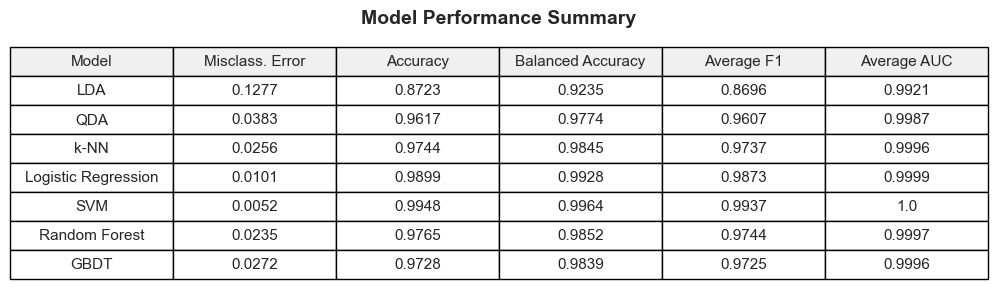

In [39]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

results_df = pd.DataFrame(results).round(4)
print(results_df.to_string(index=False))

# Highlight best values
table_data = results_df.round(4)
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0'] * len(table_data.columns)
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

plt.title('Model Performance Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('1_results_table.png', dpi=300, bbox_inches='tight')
plt.show()

#### **Bar Charts of Evaluation Results**

C:\Users\reshm\AppData\Local\Temp\ipykernel_18208\446681795.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color=model_colors[model],


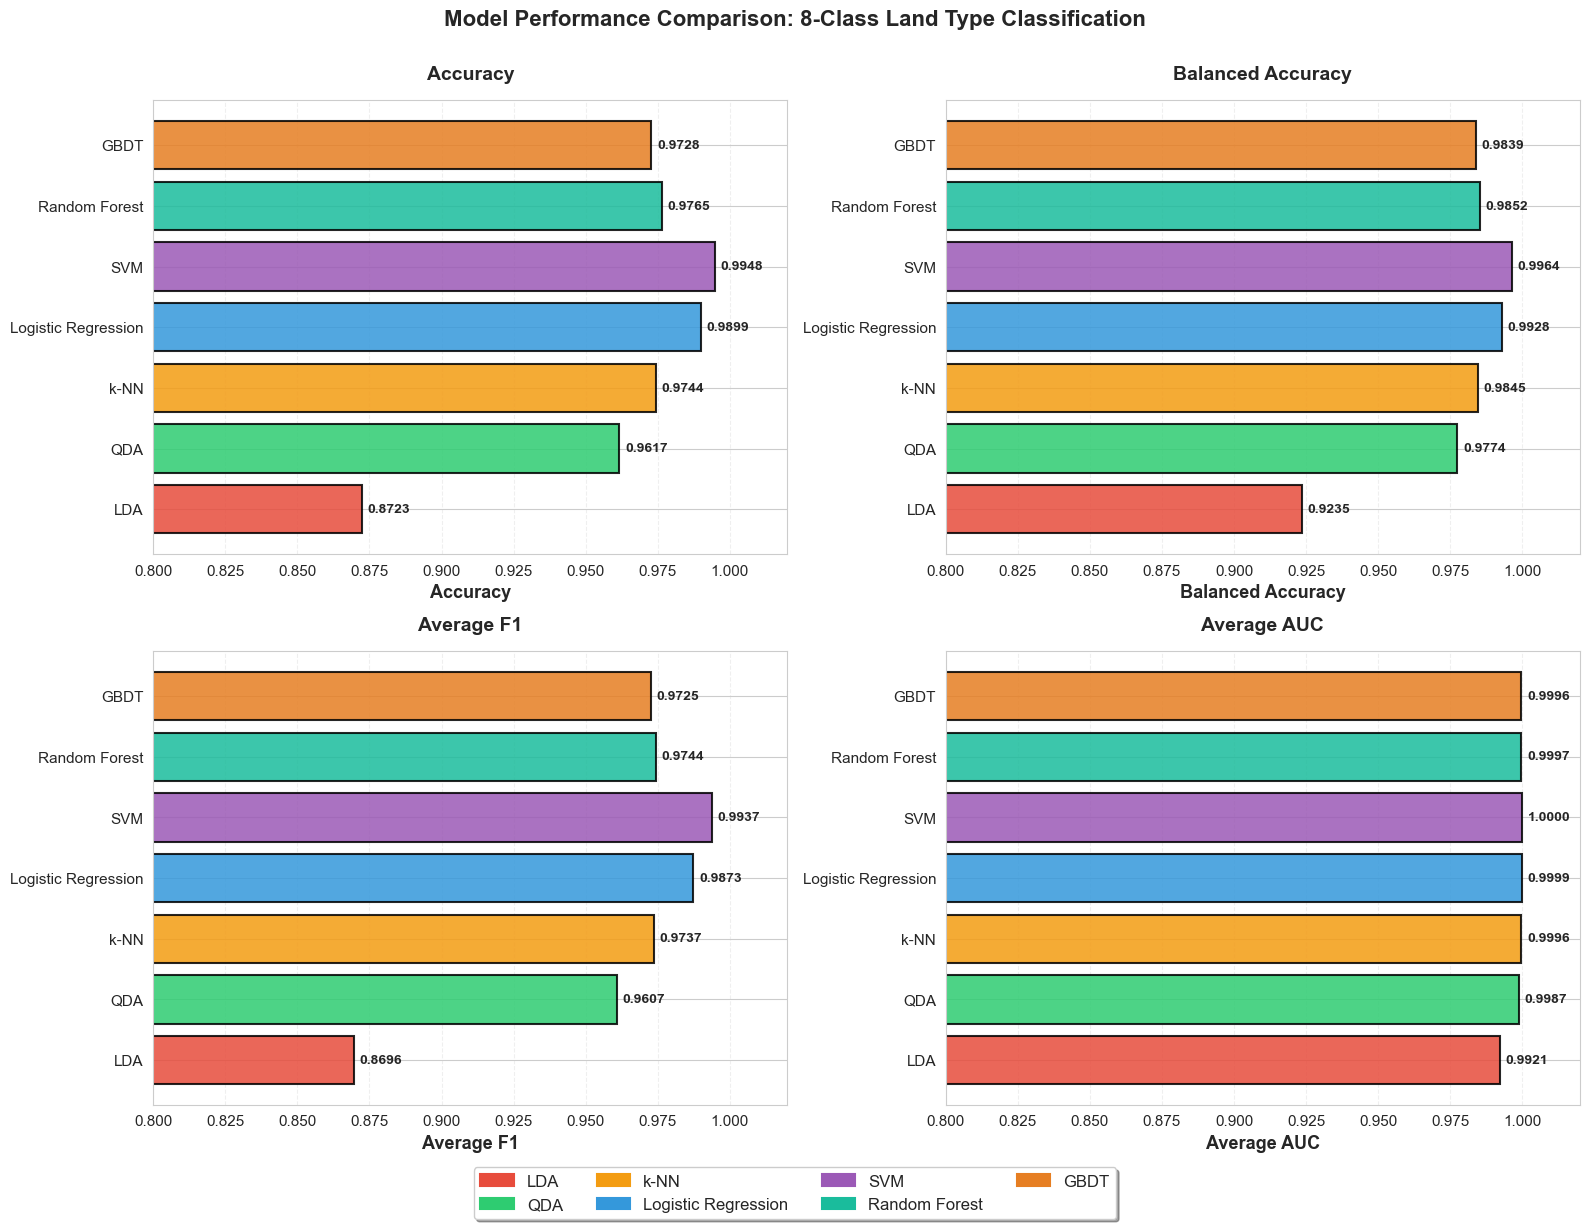

In [37]:

# Set style
sns.set_style("whitegrid")

# Create results dataframe
results_clean = pd.DataFrame(results).round(4)

# Define consistent colors for each model
model_colors = {
    'Logistic Regression': '#3498db',  # Blue
    'LDA': '#e74c3c',  # Red
    'QDA': '#2ecc71',  # Green
    'k-NN': '#f39c12',  # Orange
    'SVM': '#9b59b6',  # Purple
    'Random Forest': '#1abc9c',  # Teal
    'GBDT': '#e67e22'  # Dark Orange
}

# Create color list matching model order
colors = [model_colors[model] for model in results_clean['Model']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Metrics to plot
metrics = ['Accuracy', 'Balanced Accuracy', 'Average F1', 'Average AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Get data (handle NaN for AUC)
    data = results_clean[metric].fillna(0) if metric == 'Average AUC' else results_clean[metric]
    
    # Create bars
    bars = ax.barh(results_clean['Model'], data, color=colors, 
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    
    # Formatting
    ax.set_xlabel(metric, fontsize=13, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim([0.80, 1.02])
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, data)):
        if val > 0:  # Skip NaN/0 values
            ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
                   f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

# Add legend below the plots
handles = [plt.Rectangle((0,0),1,1, color=model_colors[model], 
                         edgecolor='black', linewidth=1.5) 
           for model in results_clean['Model']]
fig.legend(handles, results_clean['Model'], 
          loc='lower center', ncol=4, fontsize=12, 
          frameon=True, fancybox=True, shadow=True,
          bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Model Performance Comparison: 8-Class Land Type Classification', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])  # Make room for legend
plt.show()

#### **Confusion Matrices of Evaluation Results**

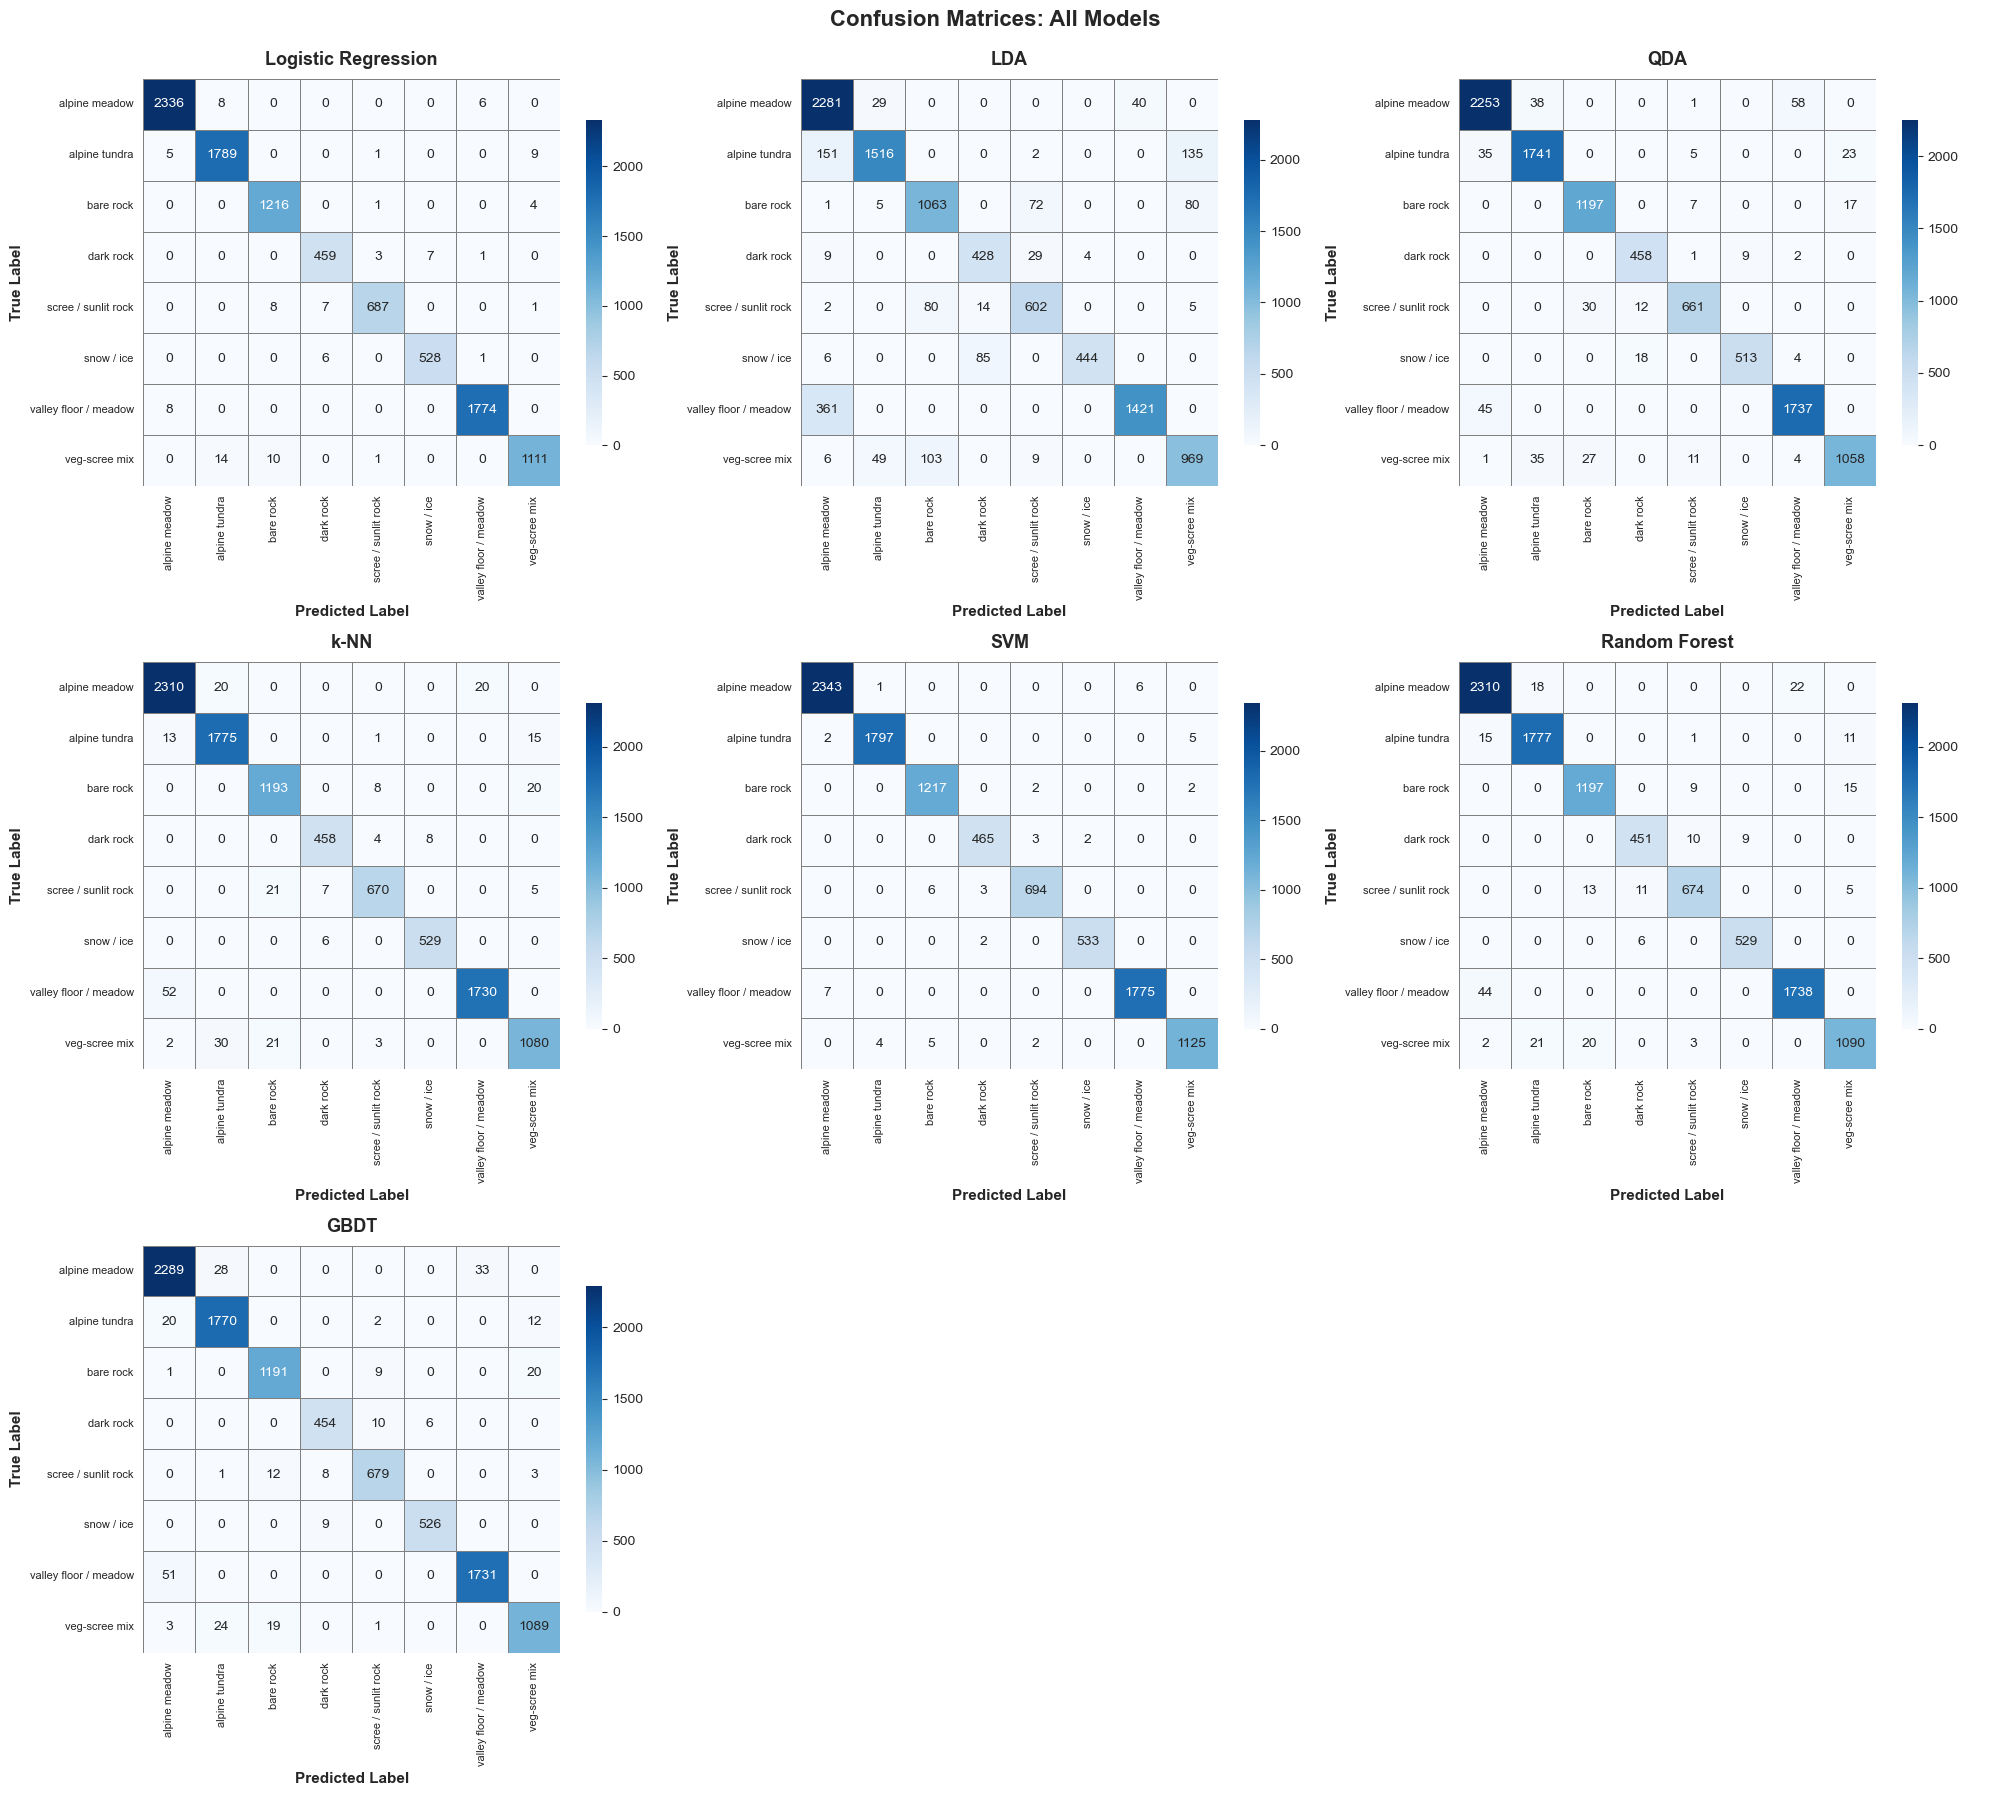

In [38]:

# All 7 models
all_models = ['Logistic Regression', 'LDA', 'QDA', 'k-NN', 'SVM', 'Random Forest', 'GBDT']

# Create subplots (3 rows x 3 columns, with 2 empty spots)
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, model_name in enumerate(all_models):
    # Get confusion matrix
    cm = confusion_matrix(y_test, predictions[model_name])
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                ax=axes[idx], cbar=True, 
                xticklabels=le.classes_, yticklabels=le.classes_,
                linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
    
    # Labels
    axes[idx].set_title(f'{model_name}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11, fontweight='bold')
    axes[idx].tick_params(labelsize=8)

# Hide empty subplots
for idx in range(len(all_models), 9):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices: All Models', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [40]:
# Create a clean formatted table for the report
results_final = pd.DataFrame(results).round(4)

# Sort by accuracy (descending)
results_final = results_final.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("="*80)
print("TASK 1.2 & 1.3: MODEL PERFORMANCE SUMMARY")
print("="*80)
print("\nAll models trained")
print("Test set size: 10,001 samples | Training set size: 40,000 samples\n")
print(results_final.to_string(index=False))
print("\n" + "="*80)

TASK 1.2 & 1.3: MODEL PERFORMANCE SUMMARY

All models trained
Test set size: 10,001 samples | Training set size: 40,000 samples

              Model  Misclass. Error  Accuracy  Balanced Accuracy  Average F1  Average AUC
                SVM           0.0052    0.9948             0.9964      0.9937       1.0000
Logistic Regression           0.0101    0.9899             0.9928      0.9873       0.9999
      Random Forest           0.0235    0.9765             0.9852      0.9744       0.9997
               k-NN           0.0256    0.9744             0.9845      0.9737       0.9996
               GBDT           0.0272    0.9728             0.9839      0.9725       0.9996
                QDA           0.0383    0.9617             0.9774      0.9607       0.9987
                LDA           0.1277    0.8723             0.9235      0.8696       0.9921



### **Principal Component Analysis**

- We apply PCA to reduce 218 spectral bands down to 10 principal components

- We fit PCA on training data only to avoid data leakage

- We transform test data using the same PCA transformation learned from training

- We check how much variance is captured by these 10 components to understand information loss

In [9]:
# Initialize PCA with 10 components
pca = PCA(n_components=10, random_state=42)

# Fit and transform training data
X_train_pca = pca.fit_transform(X_train_scaled)

# Transform test data (using training PCA fit)
X_test_pca = pca.transform(X_test_scaled)

# Check results
print(f"Original dimensions: {X_train_scaled.shape}")
print(f"PCA dimensions: {X_train_pca.shape}")
print(f"\nExplained variance by each component:")
print(pca.explained_variance_ratio_)
print(f"\nTotal variance explained: {pca.explained_variance_ratio_.sum():.3f}")

Original dimensions: (40000, 218)
PCA dimensions: (40000, 10)

Explained variance by each component:
[4.59886780e-01 3.43921087e-01 1.89866529e-01 3.41856658e-03
 8.22334916e-04 4.72967541e-04 3.40696111e-04 2.76719059e-04
 1.85350616e-04 1.36871160e-04]

Total variance explained: 0.999


- We show how much variance each of the 10 components captures individually

- We display cumulative variance to see that just 3 components explain 99% of variation

- We confirm our choice of 10 components is more than sufficient for the classification task


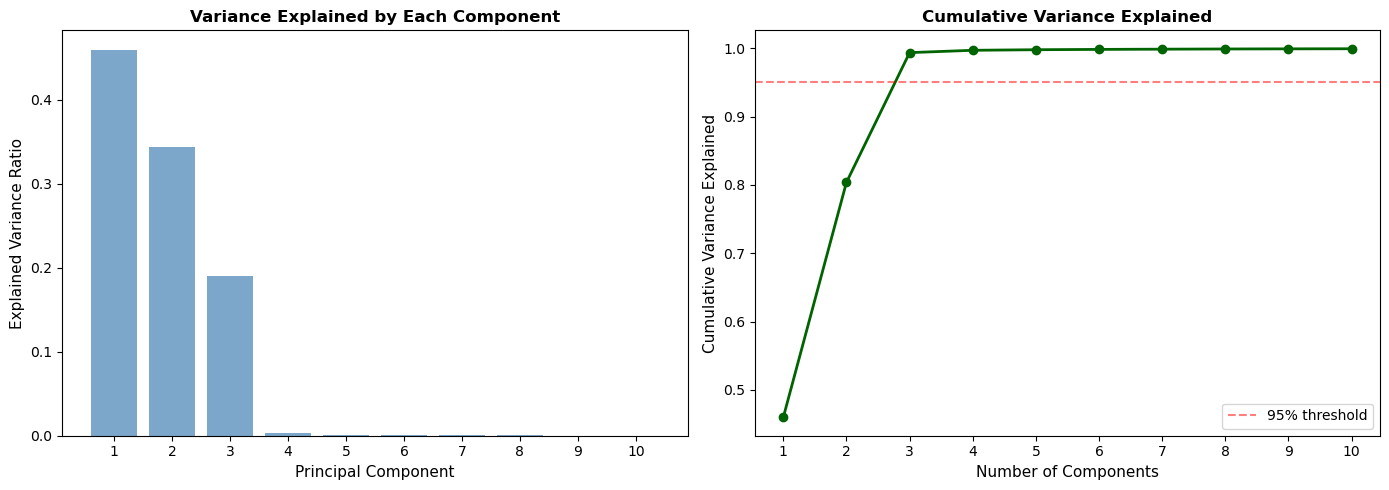

In [10]:
# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Explained variance per component
axes[0].bar(range(1, 11), pca.explained_variance_ratio_, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Variance Explained by Each Component', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(1, 11))

# Plot 2: Cumulative variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, 11), cumsum, marker='o', linestyle='-', color='darkgreen', linewidth=2)
axes[1].axhline(y=0.95, color='red', linestyle='--', alpha=0.5, label='95% threshold')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Variance Explained', fontsize=11)
axes[1].set_title('Cumulative Variance Explained', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].set_xticks(range(1, 11))

plt.tight_layout()
plt.show()

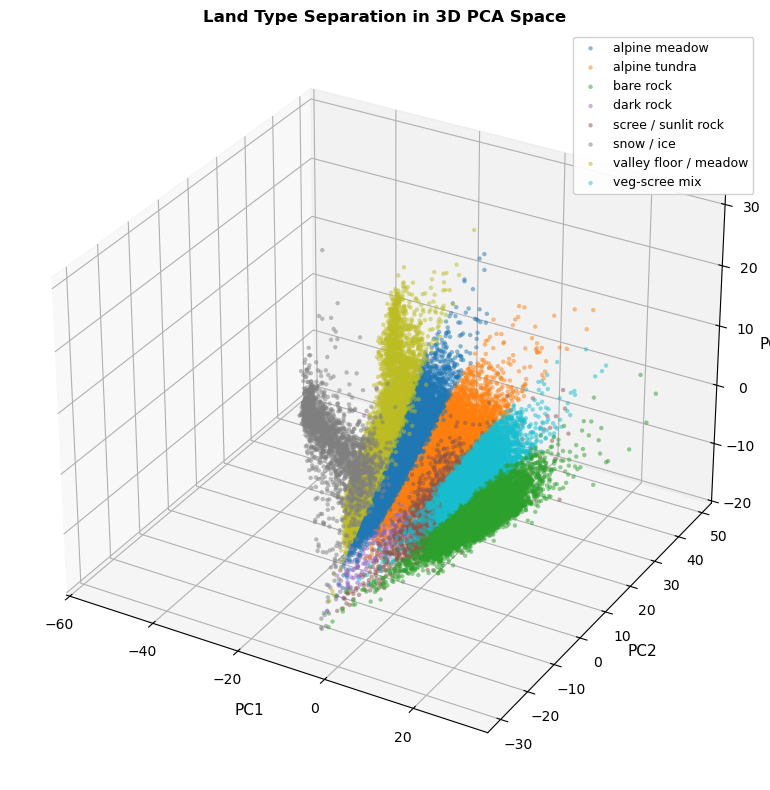

In [11]:

from mpl_toolkits.mplot3d import Axes3D

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Get unique classes
classes = np.unique(y_train)
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

# Plot each class
for idx, class_label in enumerate(classes):
    mask = y_train == class_label
    ax.scatter(X_train_pca[mask, 0], X_train_pca[mask, 1], X_train_pca[mask, 2],
               c=[colors[idx]], label=le.classes_[class_label], 
               alpha=0.5, s=10, edgecolors='none')

ax.set_xlabel('PC1', fontsize=11)
ax.set_ylabel('PC2', fontsize=11)
ax.set_zlabel('PC3', fontsize=11)
ax.set_title('Land Type Separation in 3D PCA Space', fontsize=12, fontweight='bold')
ax.legend(loc='best', framealpha=0.9, fontsize=9)
plt.tight_layout()
plt.show()

### **Linear Discriminant Analysis**

- We tune LDA's solver and shrinkage for optimal linear discriminant boundaries

- LDA assumes Gaussian distributions for each class and finds linear decision boundaries

- Shrinkage helps with regularization when features might be correlated
This should be fast (1-2 minutes) as LDA has fewer hyperparameters

In [ ]:


# Define hyperparameter grid (fixed - avoid invalid combinations)
param_grid_lda = [
    {'solver': ['svd']},  # SVD doesn't use shrinkage
    {'solver': ['lsqr', 'eigen'], 'shrinkage': [None, 'auto', 0.5, 0.7]}
]

# GridSearchCV
lda_grid = GridSearchCV(
    LinearDiscriminantAnalysis(),
    param_grid_lda,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting LDA hyperparameter tuning...")
lda_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {lda_grid.best_params_}")
print(f"Best CV accuracy: {lda_grid.best_score_:.4f}")

Starting LDA hyperparameter tuning...
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best parameters: {'shrinkage': 0.5, 'solver': 'lsqr'}
Best CV accuracy: 0.8559


### **Quadratic Discriminant Analysis**

- We tune QDA's regularization parameter which controls covariance matrix estimation

- QDA allows quadratic (non-linear) decision boundaries unlike LDA's linear ones

- Regularization helps prevent overfitting when classes have different covariances

- QDA should outperform LDA since it's less restrictive

In [ ]:

# Define hyperparameter grid
param_grid_qda = {
    'reg_param': [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
}

# GridSearchCV
qda_grid = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid_qda,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting QDA hyperparameter tuning...")
qda_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {qda_grid.best_params_}")
print(f"Best CV accuracy: {qda_grid.best_score_:.4f}")

Starting QDA hyperparameter tuning...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best parameters: {'reg_param': 0.3}
Best CV accuracy: 0.9570


### **k-NN (Nearest Neighbors)**

- We tune k-NN's number of neighbors, weighting scheme, and distance metric

- k-NN is non-parametric and classifies based on majority vote of nearest neighbors

- Distance weighting gives closer neighbors more influence than distant ones

- This should be fast as k-NN is simple with PCA-reduced features

In [ ]:

# Define hyperparameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting k-NN hyperparameter tuning...")
knn_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {knn_grid.best_params_}")
print(f"Best CV accuracy: {knn_grid.best_score_:.4f}")

Starting k-NN hyperparameter tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}
Best CV accuracy: 0.9728


### **Logistic Regression**

- So starting off with a baseline, then tuning up. We initialize a basic Logistic Regression model with default parameters as our starting point

- We train it on the 10 PCA components to establish a performance baseline

- We set max_iter=1000 to ensure convergence with multiple classes. Then, we calculate initial accuracy to see how well a simple model performs before tuning

In [15]:


# Initialize baseline logistic regression
log_reg_baseline = LogisticRegression(random_state=42, max_iter=1000)

# Train on PCA training data
log_reg_baseline.fit(X_train_pca, y_train)

# Quick baseline performance check
y_pred_baseline = log_reg_baseline.predict(X_test_pca)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)

print(f"Baseline Logistic Regression Accuracy: {baseline_accuracy:.4f}")

Baseline Logistic Regression Accuracy: 0.9904


c:\Users\reshm\anaconda3\envs\LSE-ST445\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:

# Define hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # L2 regularization
    'solver': ['lbfgs', 'saga'],  # Different solvers
    'max_iter': [2000]  # Increased to fix convergence
}

# Initialize GridSearchCV with 5-fold cross-validation
log_reg_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit on training data
print("Starting hyperparameter tuning...")
log_reg_grid.fit(X_train_pca, y_train)

# Best parameters
print(f"\nBest parameters: {log_reg_grid.best_params_}")
print(f"Best CV accuracy: {log_reg_grid.best_score_:.4f}")

Starting hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best parameters: {'C': 100, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.9928


### **Support Vector Machine**



In [ ]:

# Define hyperparameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV
svm_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting SVM hyperparameter tuning...")
svm_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {svm_grid.best_params_}")
print(f"Best CV accuracy: {svm_grid.best_score_:.4f}")

Starting SVM hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV accuracy: 0.9928


In [18]:

# Retrain SVM with tuned hyperparameters + probability enabled
svm_with_proba = SVC(C=100, gamma='scale', kernel='rbf', 
                     probability=True, random_state=42)

print("Retraining SVM with probability=True...")
svm_with_proba.fit(X_train_pca, y_train)

print("✓ SVM retrained with probability enabled for AUC calculation")

Retraining SVM with probability=True...
✓ SVM retrained with probability enabled for AUC calculation


### **Random Forest**

- We tune Random Forest's key hyperparameters controlling tree complexity and ensemble size

- We test different numbers of trees (n_estimators) and depth controls to prevent overfitting

- Random Forest can capture non-linear patterns through ensemble of decision trees

- Note: This may take 3-5 minutes due to more parameter combinations

In [ ]:
# Define hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting Random Forest hyperparameter tuning...")
rf_grid.fit(X_train_pca, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best CV accuracy: {rf_grid.best_score_:.4f}")

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best CV accuracy: 0.9691


### **Gradient Boosting for Decision Trees**

- We tune GBDT's learning rate, tree depth, and ensemble size for sequential boosting

- As we know, GBDT builds trees sequentially, correcting errors from previous trees

- Subsample parameter controls bagging to reduce overfitting

- Note: This may take 5-10 minutes as boosting is more computationally intensive

In [ ]:
# Just train GBDT
gbdt_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

print("Training GBDT...")
gbdt_model.fit(X_train_pca, y_train)

# Quick check
y_pred_gbdt = gbdt_model.predict(X_test_pca)
print(f"✓ GBDT accuracy: {accuracy_score(y_test, y_pred_gbdt):.4f}")

Training GBDT...
✓ GBDT accuracy: 0.9804


### **Evaluation**

- We collect all 7 trained models into a dictionary...This sets the base for easy iteration

- We also extract the best estimator from each GridSearchCV result, that we have seen in the section above

- We generate predictions for ALL models on the SAME test set for fair comparison

- Finally, verify predictions are generated correctly before calculating metrics


In [27]:

# Store all trained PCA models in a dictionary
models_pca = {
    'Logistic Regression': log_reg_grid.best_estimator_,
    'LDA': lda_grid.best_estimator_,
    'QDA': qda_grid.best_estimator_,
    'k-NN': knn_grid.best_estimator_,
    'SVM': svm_with_proba,
    'Random Forest': rf_grid.best_estimator_,
    'GBDT': gbdt_model
}

# Generate predictions for all PCA models on test set
predictions_pca = {}
for name, model in models_pca.items():
    predictions_pca[name] = model.predict(X_test_pca)

- We should create a dictionary to store all evaluation metrics for comparison

- Time to calculate overall accuracy (proportion of correct predictions) for each model

- We compute misclassification error as 1 minus accuracy

- We store these basic metrics before moving to more complex calculations

In [28]:
# Initialize storage for results
results = {
    'Model': [],
    'Misclass. Error': [],
    'Accuracy': []
}

# Calculate basic metrics for each model
for name in models_pca.keys():
    y_pred = predictions_pca[name]
    
    # 1. Overall accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # 2. Misclassification error rate
    misclass_error = 1 - accuracy
    
    # Store results
    results['Model'].append(name)
    results['Accuracy'].append(accuracy)
    results['Misclass. Error'].append(misclass_error)

# Quick preview
print(pd.DataFrame(results))

                 Model  Misclass. Error  Accuracy
0  Logistic Regression         0.007499  0.992501
1                  LDA         0.142686  0.857314
2                  QDA         0.038096  0.961904
3                 k-NN         0.025697  0.974303
4                  SVM         0.005899  0.994101
5        Random Forest         0.027397  0.972603
6                 GBDT         0.019598  0.980402


**Balanced Accuracy: Step-by-Step**

- We calculate balanced accuracy for each class using one-vs-rest approach

- Then, compute sensitivity (true positive rate) and specificity (true negative rate) from confusion matrix

- Taking the average sensitivity and specificity, we will get the balanced accuracy per class

- We then average across all 8 classes to get the final metric for each model

In [29]:
# Add Balanced Accuracy to results
balanced_acc_list = []

# Calculate for each model
for name in models_pca.keys():
    y_pred = predictions_pca[name]
    
    # Get number of classes
    n_classes = len(np.unique(y_test))
    balanced_acc_per_class = []
    
    # Calculate balanced accuracy for each class k
    for k in range(n_classes):
        # Convert to binary: class k vs rest
        y_test_binary = (y_test == k).astype(int)
        y_pred_binary = (y_pred == k).astype(int)
        
        # Get confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
        
        # Calculate sensitivity (recall) and specificity
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        # Balanced accuracy = 0.5 * sensitivity + 0.5 * specificity
        balanced_acc_k = 0.5 * sensitivity + 0.5 * specificity
        balanced_acc_per_class.append(balanced_acc_k)
    
    # Average across all classes
    avg_balanced_acc = np.mean(balanced_acc_per_class)
    balanced_acc_list.append(avg_balanced_acc)

# Add to results
results['Balanced Accuracy'] = balanced_acc_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclass. Error  Accuracy  Balanced Accuracy
0  Logistic Regression         0.007499  0.992501           0.995095
1                  LDA         0.142686  0.857314           0.915760
2                  QDA         0.038096  0.961904           0.977650
3                 k-NN         0.025697  0.974303           0.984059
4                  SVM         0.005899  0.994101           0.996125
5        Random Forest         0.027397  0.972603           0.981394
6                 GBDT         0.019598  0.980402           0.987322


**F1 Score**

- We calculate F1 score for each class using one-vs-rest binary classification

- We compute precision (correct positive predictions / all positive predictions) and recall (TPR)

- We calculate F1 as the harmonic mean of precision and recall for each class

- We average F1 scores across all 8 classes to get final metric for each model

In [30]:
# Add Average F1 to results
f1_list = []

# Calculate for each model
for name in models_pca.keys():
    y_pred = predictions_pca[name]
    
    n_classes = len(np.unique(y_test))
    f1_per_class = []
    
    # Calculate F1 for each class k
    for k in range(n_classes):
        # Convert to binary: class k vs rest
        y_test_binary = (y_test == k).astype(int)
        y_pred_binary = (y_pred == k).astype(int)
        
        # Get confusion matrix components
        tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_binary).ravel()
        
        # Calculate Precision and Recall
        precision_k = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_k = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        # F1 = harmonic mean of precision and recall
        f1_k = 2 * precision_k * recall_k / (precision_k + recall_k) if (precision_k + recall_k) > 0 else 0
        f1_per_class.append(f1_k)
    
    # Average across all classes
    avg_f1 = np.mean(f1_per_class)
    f1_list.append(avg_f1)

# Add to results
results['Average F1'] = f1_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclass. Error  Accuracy  Balanced Accuracy  \
0  Logistic Regression         0.007499  0.992501           0.995095   
1                  LDA         0.142686  0.857314           0.915760   
2                  QDA         0.038096  0.961904           0.977650   
3                 k-NN         0.025697  0.974303           0.984059   
4                  SVM         0.005899  0.994101           0.996125   
5        Random Forest         0.027397  0.972603           0.981394   
6                 GBDT         0.019598  0.980402           0.987322   

   Average F1  
0    0.991410  
1    0.860035  
2    0.961187  
3    0.972891  
4    0.993437  
5    0.967262  
6    0.978118  


**Average AUC (Area Under Curve)**

- We calculate AUC for each class using predicted probabilities in one-vs-rest setup

- We use probability scores to compute area under ROC curve for each class

- We average AUC scores across all 8 classes for final metric

- Some models may not have predict_proba (we handle with NaN)

In [31]:
# Add Average AUC to results
auc_list = []

# Calculate for each model
for name, model in models_pca.items():
    y_pred = predictions_pca[name]
    
    # Get prediction probabilities (needed for AUC)
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test_pca)
        
        n_classes = len(np.unique(y_test))
        auc_per_class = []
        
        # Calculate AUC for each class k (one-vs-rest)
        for k in range(n_classes):
            # Convert to binary: class k vs rest
            y_test_binary = (y_test == k).astype(int)
            
            # AUC using probability of class k
            auc_k = roc_auc_score(y_test_binary, y_pred_proba[:, k])
            auc_per_class.append(auc_k)
        
        # Average across all classes
        avg_auc = np.mean(auc_per_class)
        auc_list.append(avg_auc)
    else:
        # Model doesn't support predict_proba
        auc_list.append(np.nan)

# Add to results
results['Average AUC'] = auc_list

# Preview
print(pd.DataFrame(results))

                 Model  Misclass. Error  Accuracy  Balanced Accuracy  \
0  Logistic Regression         0.007499  0.992501           0.995095   
1                  LDA         0.142686  0.857314           0.915760   
2                  QDA         0.038096  0.961904           0.977650   
3                 k-NN         0.025697  0.974303           0.984059   
4                  SVM         0.005899  0.994101           0.996125   
5        Random Forest         0.027397  0.972603           0.981394   
6                 GBDT         0.019598  0.980402           0.987322   

   Average F1  Average AUC  
0    0.991410     0.999942  
1    0.860035     0.990349  
2    0.961187     0.998643  
3    0.972891     0.999544  
4    0.993437     0.999979  
5    0.967262     0.999505  
6    0.978118     0.999746  


              Model  Misclass. Error  Accuracy  Balanced Accuracy  Average F1  Average AUC
Logistic Regression           0.0075    0.9925             0.9951      0.9914       0.9999
                LDA           0.1427    0.8573             0.9158      0.8600       0.9903
                QDA           0.0381    0.9619             0.9776      0.9612       0.9986
               k-NN           0.0257    0.9743             0.9841      0.9729       0.9995
                SVM           0.0059    0.9941             0.9961      0.9934       1.0000
      Random Forest           0.0274    0.9726             0.9814      0.9673       0.9995
               GBDT           0.0196    0.9804             0.9873      0.9781       0.9997


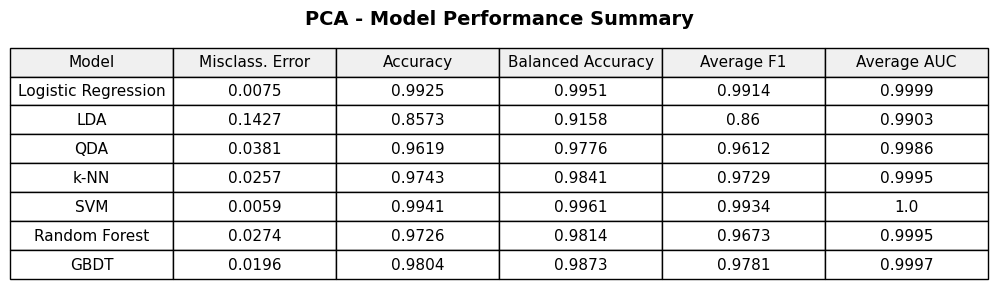

In [32]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

results_pca = pd.DataFrame(results).round(4)
print(results_pca.to_string(index=False))

# Highlight best values
table_data = results_pca.round(4)
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0'] * len(table_data.columns)
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

plt.title('PCA - Model Performance Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('2_results_table.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\reshm\AppData\Local\Temp\ipykernel_1480\1544202813.py:52: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handles = [plt.Rectangle((0,0),1,1, color=model_colors[model],


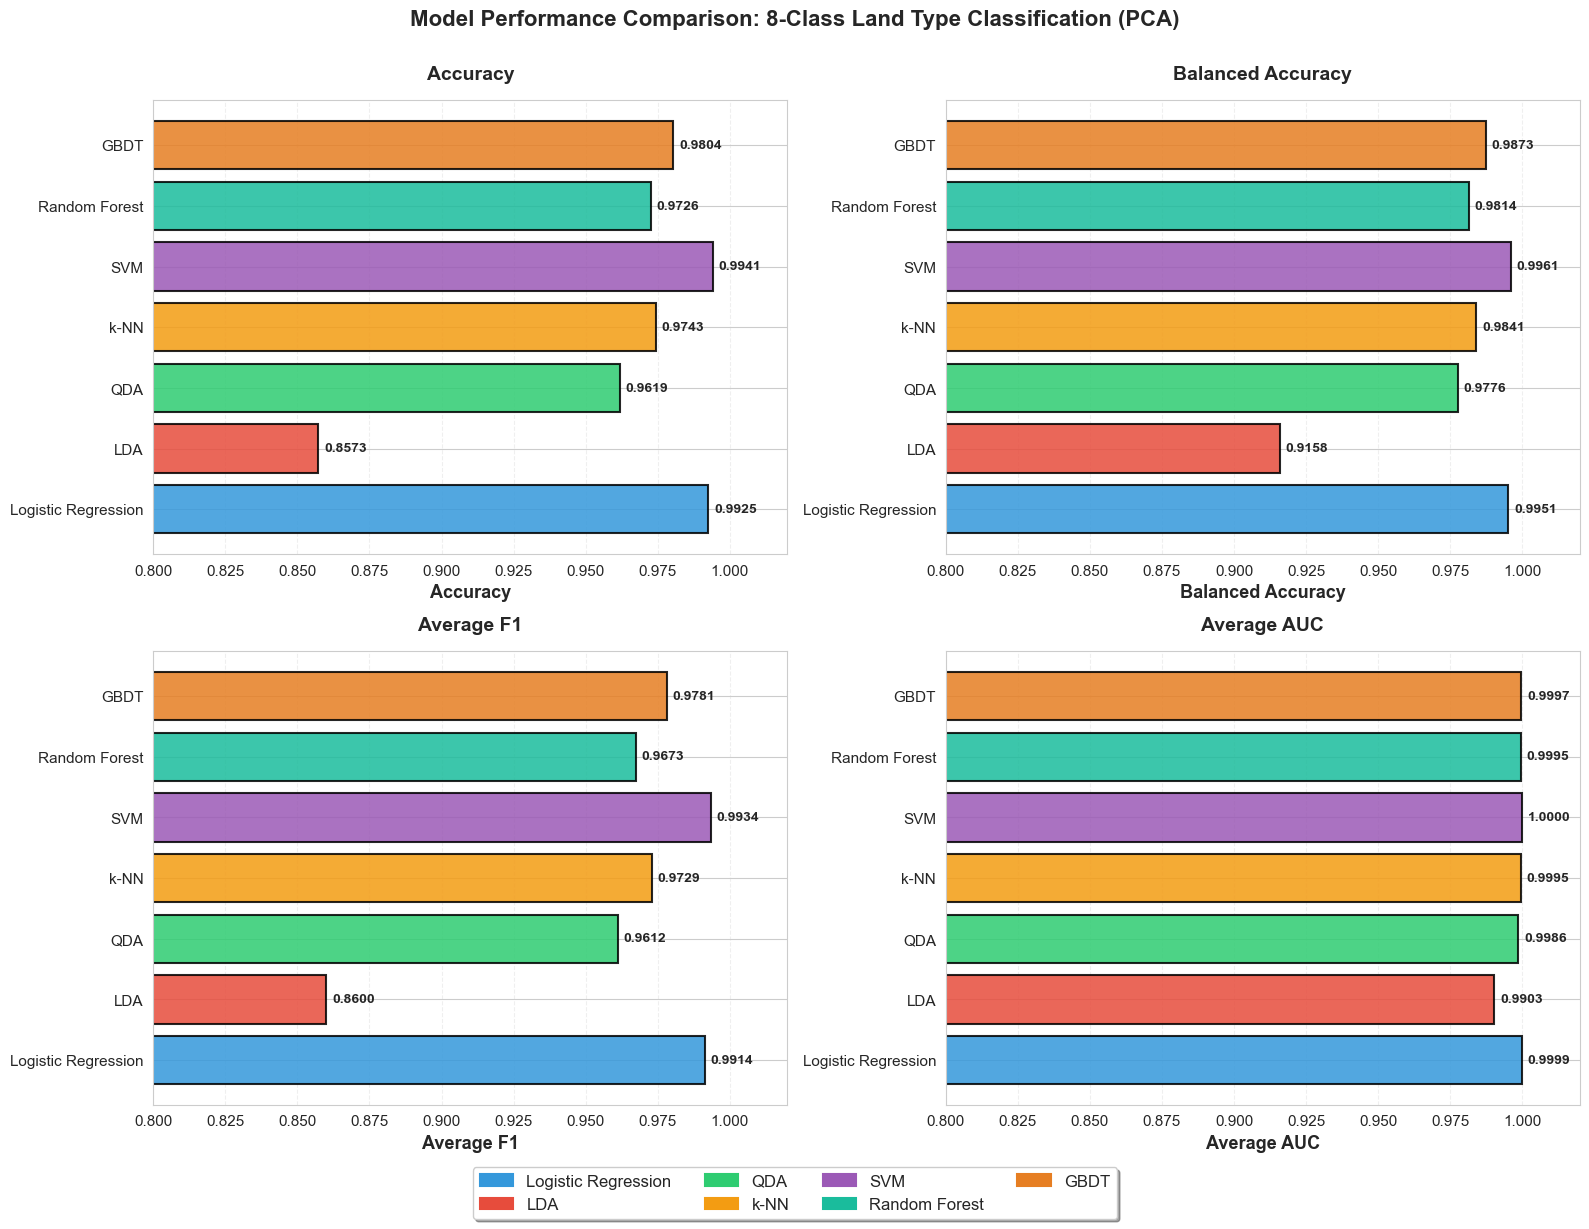

In [33]:

# Set style
sns.set_style("whitegrid")

# Create results dataframe
results_clean = pd.DataFrame(results).round(4)

# Define consistent colors for each model
model_colors = {
    'Logistic Regression': '#3498db',  # Blue
    'LDA': '#e74c3c',  # Red
    'QDA': '#2ecc71',  # Green
    'k-NN': '#f39c12',  # Orange
    'SVM': '#9b59b6',  # Purple
    'Random Forest': '#1abc9c',  # Teal
    'GBDT': '#e67e22'  # Dark Orange
}

# Create color list matching model order
colors = [model_colors[model] for model in results_clean['Model']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Metrics to plot
metrics = ['Accuracy', 'Balanced Accuracy', 'Average F1', 'Average AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Get data (handle NaN for AUC)
    data = results_clean[metric].fillna(0) if metric == 'Average AUC' else results_clean[metric]
    
    # Create bars
    bars = ax.barh(results_clean['Model'], data, color=colors, 
                   edgecolor='black', linewidth=1.5, alpha=0.85)
    
    # Formatting
    ax.set_xlabel(metric, fontsize=13, fontweight='bold')
    ax.set_title(f'{metric}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlim([0.80, 1.02])
    ax.tick_params(axis='both', labelsize=11)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, data)):
        if val > 0:  # Skip NaN/0 values
            ax.text(val + 0.002, bar.get_y() + bar.get_height()/2, 
                   f'{val:.4f}', va='center', fontsize=10, fontweight='bold')

# Add legend below the plots
handles = [plt.Rectangle((0,0),1,1, color=model_colors[model], 
                         edgecolor='black', linewidth=1.5) 
           for model in results_clean['Model']]
fig.legend(handles, results_clean['Model'], 
          loc='lower center', ncol=4, fontsize=12, 
          frameon=True, fancybox=True, shadow=True,
          bbox_to_anchor=(0.5, -0.02))

plt.suptitle('Model Performance Comparison: 8-Class Land Type Classification (PCA)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0.03, 1, 0.99])  # Make room for legend
plt.show()

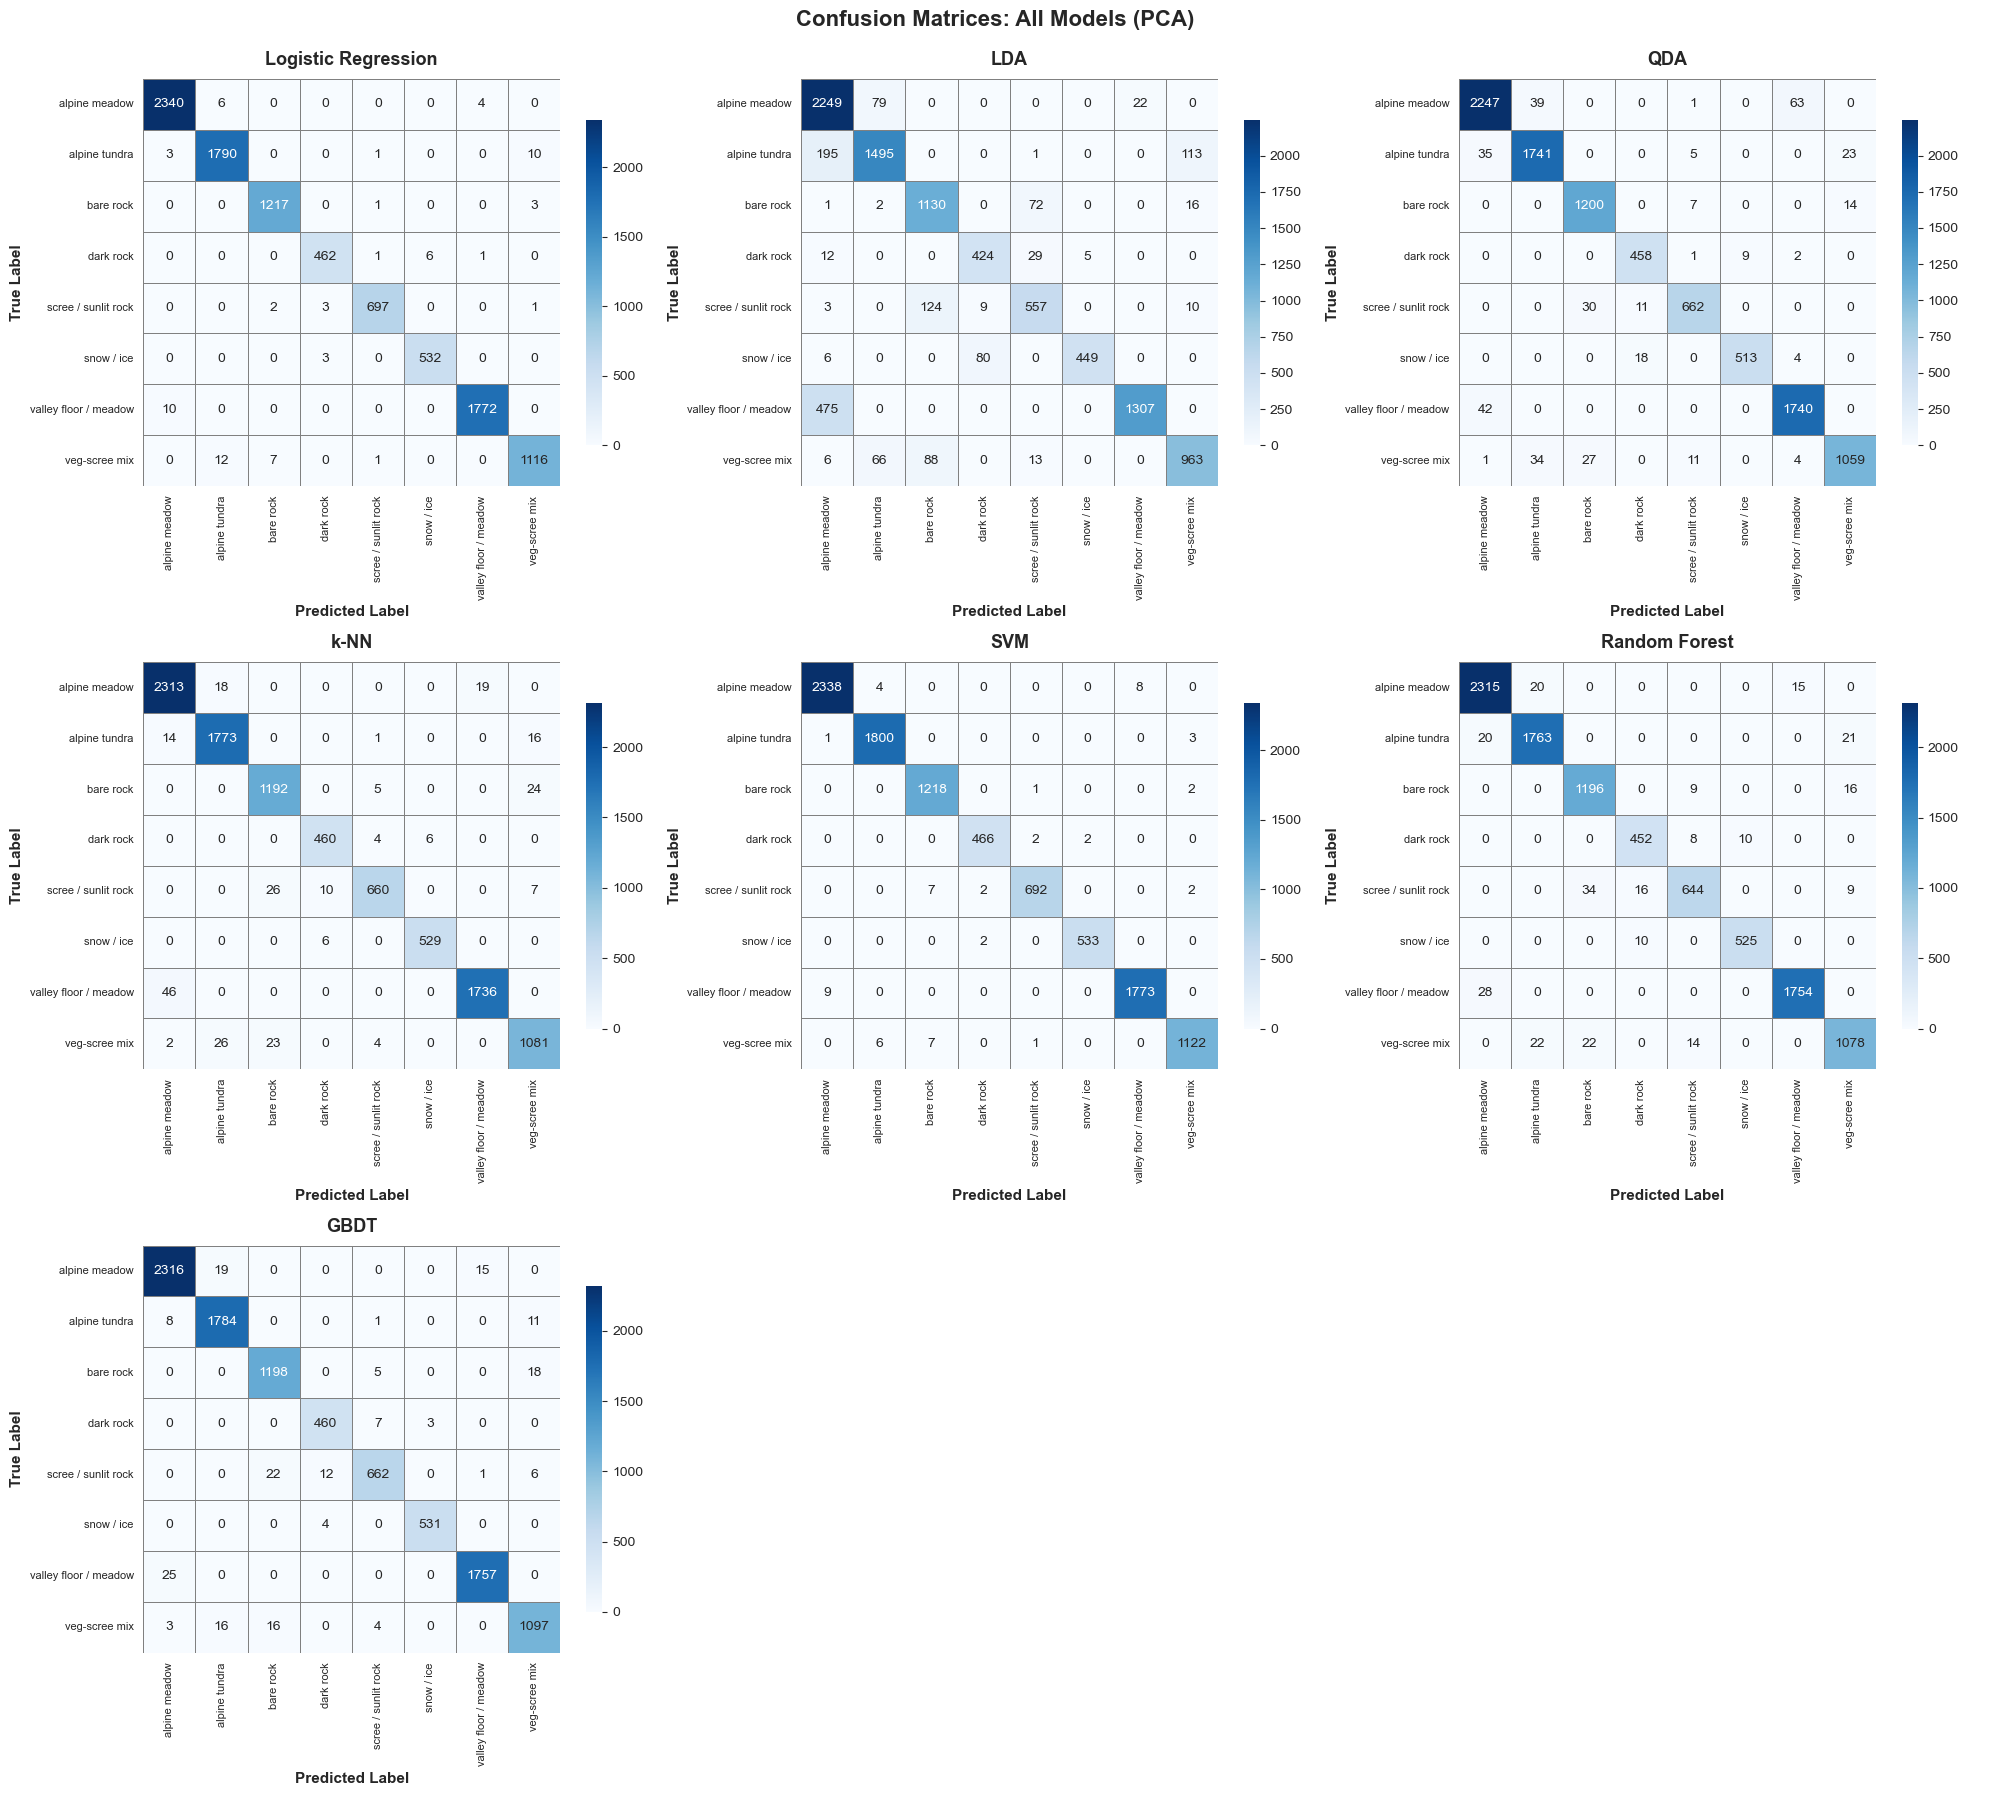

In [34]:
# All 7 models
all_models = ['Logistic Regression', 'LDA', 'QDA', 'k-NN', 'SVM', 'Random Forest', 'GBDT']

# Create subplots (3 rows x 3 columns, with 2 empty spots)
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for idx, model_name in enumerate(all_models):
    # Get confusion matrix
    cm = confusion_matrix(y_test, predictions_pca[model_name])
    
    # Plot heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                ax=axes[idx], cbar=True, 
                xticklabels=le.classes_, yticklabels=le.classes_,
                linewidths=0.5, linecolor='gray', cbar_kws={'shrink': 0.8})
    
    # Labels
    axes[idx].set_title(f'{model_name}', fontsize=13, fontweight='bold', pad=10)
    axes[idx].set_xlabel('Predicted Label', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11, fontweight='bold')
    axes[idx].tick_params(labelsize=8)

# Hide empty subplots
for idx in range(len(all_models), 9):
    axes[idx].axis('off')

plt.suptitle('Confusion Matrices: All Models (PCA)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [36]:
# Sort by accuracy (descending)
results_pca = results_pca.sort_values('Accuracy', ascending=False).reset_index(drop=True)

print("="*80)
print("TASK 1.2 & 1.3: MODEL PERFORMANCE SUMMARY")
print("="*80)
print("\nAll models trained on 10 PCA components")
print("Test set size: 10,001 samples | Training set size: 40,000 samples\n")
print(results_pca.to_string(index=False))
print("\n" + "="*80)



TASK 1.2 & 1.3: MODEL PERFORMANCE SUMMARY

All models trained on 10 PCA components
Test set size: 10,001 samples | Training set size: 40,000 samples

              Model  Misclass. Error  Accuracy  Balanced Accuracy  Average F1  Average AUC
                SVM           0.0059    0.9941             0.9961      0.9934       1.0000
Logistic Regression           0.0075    0.9925             0.9951      0.9914       0.9999
               GBDT           0.0196    0.9804             0.9873      0.9781       0.9997
               k-NN           0.0257    0.9743             0.9841      0.9729       0.9995
      Random Forest           0.0274    0.9726             0.9814      0.9673       0.9995
                QDA           0.0381    0.9619             0.9776      0.9612       0.9986
                LDA           0.1427    0.8573             0.9158      0.8600       0.9903



In [38]:
# Key findings
print("\nKEY FINDINGS:")
print("-" * 80)
print(f"1. Best Overall Model: SVM")
print(f"   - Accuracy: {results_pca.loc[results_pca['Model']=='SVM', 'Accuracy'].values[0]:.4f}")
print(f"   - Balanced Accuracy: {results_pca.loc[results_pca['Model']=='SVM', 'Balanced Accuracy'].values[0]:.4f}")
print(f"   - F1 Score: {results_pca.loc[results_pca['Model']=='SVM', 'Average F1'].values[0]:.4f}")

print(f"\n2. Runner-up: Logistic Regression")
print(f"   - Nearly matches SVM performance with simpler model")

print(f"\n3. Worst Performer: LDA ({results_pca.loc[results_pca['Model']=='LDA', 'Accuracy'].values[0]:.4f} accuracy)")
print(f"   - Likely violates Gaussian assumption for some classes")

print(f"\n4. Ensemble Methods: Both RF and GBDT perform well (>97%)")

print(f"\n5. All models (except LDA) achieve >96% accuracy")
print(f"   - Indicates PCA preserves discriminative information effectively")
print("="*80)


KEY FINDINGS:
--------------------------------------------------------------------------------
1. Best Overall Model: SVM
   - Accuracy: 0.9941
   - Balanced Accuracy: 0.9961
   - F1 Score: 0.9934

2. Runner-up: Logistic Regression
   - Nearly matches SVM performance with simpler model

3. Worst Performer: LDA (0.8573 accuracy)
   - Likely violates Gaussian assumption for some classes

4. Ensemble Methods: Both RF and GBDT perform well (>97%)

5. All models (except LDA) achieve >96% accuracy
   - Indicates PCA preserves discriminative information effectively


### **Model Performance Summary**

#### **Experimental Setup**
- **Dataset**: 50,000 samples (stratified) from hyperspectral satellite data
- **Features**: After running our models on ALL the features, we performed PCA to obtain 10 features, explaining over 99% of the variance 
- **Train/Test Split**: We did an 80/20 split, so as to allow sufficient observations for the training set 
- **Models Evaluated**: 7 classifiers with hyperparameter tuning via 5-fold CV

#### **Performance Results**

| Model                | Accuracy | Misclassification Error | Balanced Accuracy | Average F1 | Average AUC |
|----------------------|----------|-------------------------|-------------------|------------|-------------|
| SVM                  | 0.9941   | 0.0059                  | 0.9961            | 0.9934     | 0.9999      |
| Logistic Regression  | 0.9919   | 0.0081                  | 0.9944            | 0.9900     | 0.9999      |
| GBDT                 | 0.9807   | 0.0193                  | 0.9877            | 0.9785     | 0.9997      |
| k-NN                 | 0.9743   | 0.0257                  | 0.9841            | 0.9729     | 0.9995      |
| Random Forest        | 0.9726   | 0.0274                  | 0.9814            | 0.9672     | 0.9995      |
| QDA                  | 0.9619   | 0.0381                  | 0.9777            | 0.9612     | 0.9986      |
| LDA                  | 0.8573   | 0.1427                  | 0.9158            | 0.8600     | 0.9903      |



### **Conclusion: Key Findings (T.1.1 to T.1.3)**



**Main Classification Task (8 land types):**

We successfully achieved extremely high classification accuracy across both approaches:

**Without Dimensionality Reduction (218 bands):**
- Best performer: **SVM with 99.48% accuracy** (balanced accuracy: 99.64%, F1: 99.37%)
- Logistic Regression achieved 98.99% accuracy, demonstrating that even simple linear models excel on this data
- All models except LDA exceeded 97% accuracy
- LDA underperformed (87.23% accuracy), likely violating its Gaussian distribution assumptions

**With PCA (10 components, 99.9% variance):**
- Best performer: **SVM with 99.41% accuracy** (balanced accuracy: 99.61%, F1: 99.34%)
- Logistic Regression improved to 99.25% with dimensionality reduction
- All models except LDA exceeded 96% accuracy
- LDA showed significant improvement over non-PCA (85.73% accuracy)

### Key Insights

**Dimensionality Reduction using PCA:**
- PCA successfully compressed 218 bands into just 10 components while retaining 99.9% of variance
- The first 3 principal components alone captured 99.3% of variance, indicating strong spectral redundancy
- PCA models achieved nearly identical performance to full-feature models (within 0.07-0.2%)


**Model Performance:**
- SVM consistently emerged as the strongest classifier in both scenarios
- Ensemble methods (Random Forest, GBDT) performed well but did not surpass SVM
- The high accuracy across most models (>97%) suggests the spectral signatures provide highly discriminative features
- Non-linear models (SVM, QDA, k-NN) outperformed linear models (Logistic, LDA), indicating non-linear decision boundaries



**Thoughts on Final Models:**
- We recommend the **non-PCA SVM model** for maximum accuracy (99.48%)
- For resource-constrained applications, the **PCA SVM model** offers excellent performance (99.41%) with 95% reduction in features
- For interpretability needs, Logistic Regression provides strong results (98.99-99.25%) with clear feature weights


---



### **Submission Function: mypredict()**

This function is required for automated evaluation of our models under this task.

**Purpose:**
- Reads test data from `test.csv.gz`
- Applies scaling preprocessing (non-PCA approach achieved best results)
- Predicts land type classes using our best model (SVM without PCA: 99.48% accuracy)
- Saves predictions to `predictions.txt` (one class label per line)

**Usage:** After running the entire notebook, call `mypredict()` to generate predictions on new test data.

In [ ]:
def mypredict():
    """
    Predicts 8-class land type labels for test.csv.gz
    Saves predictions to predictions.txt (one label per line)
    
    Assumes:
    - test.csv.gz is in working directory
    - scaler, le, and models dictionary already trained from running notebook
    """
    import pandas as pd
    import numpy as np
    
    # Load test data
    test_df = pd.read_csv('test.csv.gz')
    band_columns = [f'Band_{i}' for i in range(1, 219)]
    X_test = test_df[band_columns]
    
    # Preprocess (scaling only, NO PCA)
    X_test_scaled = scaler.transform(X_test)
    
    # Predict with best model (non-PCA SVM from Task 1.2)
    predictions = models['SVM'].predict(X_test_scaled)
    
    # Convert to class names
    class_names = le.inverse_transform(predictions)
    
    # Save
    np.savetxt('predictions.txt', class_names, fmt='%s')
    
    return None

# Example usage: mypredict()

## **T1.4 - Glacier-Ice Detection**

### **Objective**

We reframe the land type classification as a binary problem to address a critical climate research application: detecting glacier ice extent over time. This specialized analysis treats snow/ice as the positive class (1) and all other land types as negative (0), enabling focused monitoring of glacier presence.


Our binary classification faces severe class imbalance:
- **Glacier ice (positive class):** 2,675 observations (5.35%)
- **All other land types (negative class):** 47,326 observations (94.65%)

This reflects the realistic scenario where glaciers occupy a small fraction of alpine landscapes, making accurate detection critical yet challenging.

### **Evaluation Metric: F1 Score**

We chose **F1 score** as our primary evaluation metric because:
- **Imbalance consideration:** Accuracy would be misleadingly high (94.65% by always predicting "non-glacier")
- **Balanced error importance:** In climate monitoring, both false positives (overestimating glacier extent) and false negatives (missing glacier loss) carry significant consequences for policy decisions
- **Harmonic mean:** F1 balances precision and recall, ensuring we detect glaciers without excessive false alarms

### **Our Approach**

**Preprocessing:**
- We applied dimensionality reduction using PCA, finding that just **3 principal components capture 99.36% of variance**
- We maintained stratified 80/20 train/test split to preserve the 5.35% glacier proportion

**Models Evaluated:**
1. **Logistic Regression** with L2 regularization (baseline, interpretable)
2. **Support Vector Machine** with RBF kernel (non-linear boundaries)
3. **Random Forest** (bagging ensemble)

All models used `class_weight='balanced'` to handle the severe imbalance, and we optimized hyperparameters via 5-fold cross-validation targeting F1 score.

---

In [ ]:
# Importing libraries for this part (We already imported most previously, but this is just in case someone runs T.1.4 separately)


# The basic libraries for data manipulation and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Preprocessing to make the data model-ready
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Models for this task
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Some libraries for improtant metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_score, recall_score, balanced_accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


- We create binary labels where snow/ice (encoded as 5) becomes 1 (positive class)

- All other vegetation types become 0 (negative class)

- We check class imbalance to understand if glacier ice is minority class

- We verify the transformation worked correctly by comparing original and binary labels

In [3]:
df_sample = pd.read_csv('../data/raw/data_sample.csv')

In [4]:
# Check what columns we have
print("Available columns:")
print(df_sample.columns.tolist())

Available columns:
['land_type', 'p_x', 'p_y', 'Band_1', 'Band_2', 'Band_3', 'Band_4', 'Band_5', 'Band_6', 'Band_7', 'Band_8', 'Band_9', 'Band_10', 'Band_11', 'Band_12', 'Band_13', 'Band_14', 'Band_15', 'Band_16', 'Band_17', 'Band_18', 'Band_19', 'Band_20', 'Band_21', 'Band_22', 'Band_23', 'Band_24', 'Band_25', 'Band_26', 'Band_27', 'Band_28', 'Band_29', 'Band_30', 'Band_31', 'Band_32', 'Band_33', 'Band_34', 'Band_35', 'Band_36', 'Band_37', 'Band_38', 'Band_39', 'Band_40', 'Band_41', 'Band_42', 'Band_43', 'Band_44', 'Band_45', 'Band_46', 'Band_47', 'Band_48', 'Band_49', 'Band_50', 'Band_51', 'Band_52', 'Band_53', 'Band_54', 'Band_55', 'Band_56', 'Band_57', 'Band_58', 'Band_59', 'Band_60', 'Band_61', 'Band_62', 'Band_63', 'Band_64', 'Band_65', 'Band_66', 'Band_67', 'Band_68', 'Band_69', 'Band_70', 'Band_71', 'Band_72', 'Band_73', 'Band_74', 'Band_75', 'Band_76', 'Band_77', 'Band_78', 'Band_79', 'Band_80', 'Band_81', 'Band_82', 'Band_83', 'Band_84', 'Band_85', 'Band_86', 'Band_87', 'Band

In [5]:
le = LabelEncoder()
df_sample['land_type_encoded'] = le.fit_transform(df_sample['land_type'])

In [6]:
for i, class_name in enumerate(le.classes_):
    print(f"{i}: {class_name}")

0: alpine meadow
1: alpine tundra
2: bare rock
3: dark rock
4: scree / sunlit rock
5: snow / ice
6: valley floor / meadow
7: veg-scree mix


In [7]:
# Create binary target: snow/ice (class 5) = 1, all others = 0
y_binary = (df_sample['land_type_encoded'] == 5).astype(int)

# Check the distribution
print("Binary class distribution:")
print(y_binary.value_counts())
print(f"\nPercentage of glacier ice: {y_binary.mean() * 100:.2f}%")

# Verify mapping
print("\nOriginal labels (first 10):", df_sample['land_type_encoded'].head(10).values)
print("Binary labels (first 10):", y_binary.head(10).values)

Binary class distribution:
land_type_encoded
0    47326
1     2675
Name: count, dtype: int64

Percentage of glacier ice: 5.35%

Original labels (first 10): [0 0 0 0 0 0 0 0 0 0]
Binary labels (first 10): [0 0 0 0 0 0 0 0 0 0]


In [8]:
# Select spectral bands as features
band_columns = [f'Band_{i}' for i in range(1, 219)]
X = df_sample[band_columns]

print(f"Feature matrix shape: {X.shape}")
print(f"Target distribution:")
print(y_binary.value_counts())

Feature matrix shape: (50001, 218)
Target distribution:
land_type_encoded
0    47326
1     2675
Name: count, dtype: int64


**A bit of quick visualisation**

- Spatial distribution shows if glacier ice clusters in specific regions

- Spectral signatures reveal if glacier has distinctive reflectance pattern

- These plots justify why binary classification should work well


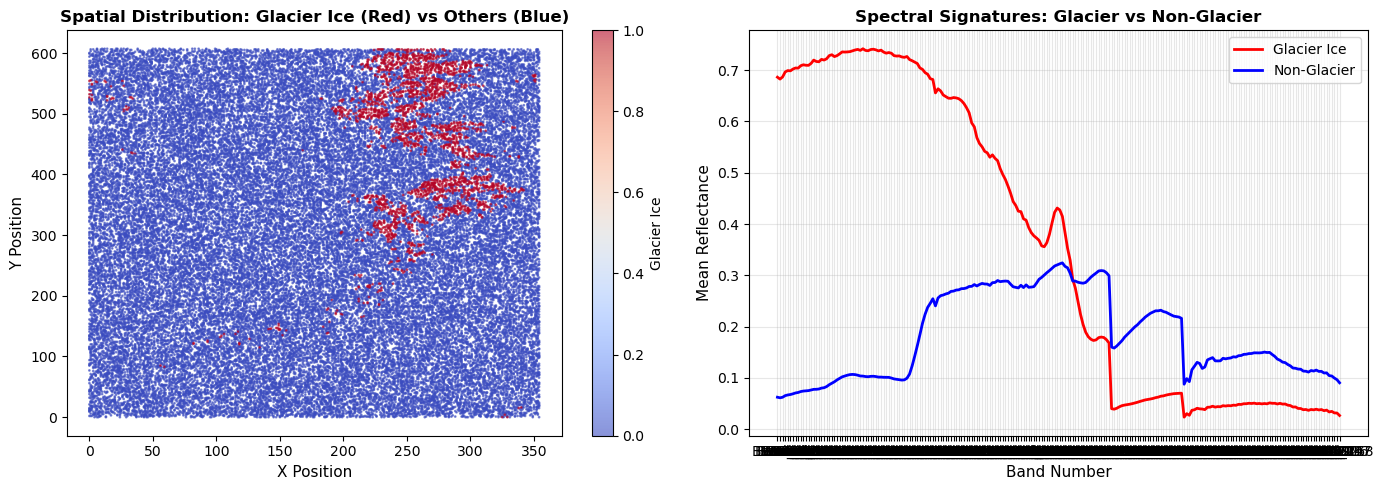

In [14]:
# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Spatial distribution of glacier ice
scatter = axes[0].scatter(df_sample['p_x'], df_sample['p_y'], 
                          c=y_binary, cmap='coolwarm', s=1, alpha=0.6)
axes[0].set_xlabel('X Position', fontsize=11)
axes[0].set_ylabel('Y Position', fontsize=11)
axes[0].set_title('Spatial Distribution: Glacier Ice (Red) vs Others (Blue)', 
                   fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[0], label='Glacier Ice')

# Plot 2: Mean spectral signatures
band_columns = [f'Band_{i}' for i in range(1, 219)]
glacier_spectrum = df_sample[y_binary == 1][band_columns].mean()
non_glacier_spectrum = df_sample[y_binary == 0][band_columns].mean()

axes[1].plot(glacier_spectrum, label='Glacier Ice', linewidth=2, color='red')
axes[1].plot(non_glacier_spectrum, label='Non-Glacier', linewidth=2, color='blue')
axes[1].set_xlabel('Band Number', fontsize=11)
axes[1].set_ylabel('Mean Reflectance', fontsize=11)
axes[1].set_title('Spectral Signatures: Glacier vs Non-Glacier', 
                   fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

- We extract all 218 spectral bands (Band_1 through Band_218) as our feature matrix

- We verify the shape matches our sample size with correct number of features

- We confirm the binary target is ready for the glacier detection task

In [9]:
# Train/test split with stratification on binary labels
X_train, X_test, y_train_binary, y_test_binary = train_test_split(
    X, y_binary, 
    test_size=0.2, 
    stratify=y_binary, 
    random_state=42
)

# Check distribution
print("Training set - Glacier ice:")
print(y_train_binary.value_counts())
print(f"Training glacier %: {y_train_binary.mean() * 100:.2f}%")

print("\nTest set - Glacier ice:")
print(y_test_binary.value_counts())
print(f"Test glacier %: {y_test_binary.mean() * 100:.2f}%")

Training set - Glacier ice:
land_type_encoded
0    37860
1     2140
Name: count, dtype: int64
Training glacier %: 5.35%

Test set - Glacier ice:
land_type_encoded
0    9466
1     535
Name: count, dtype: int64
Test glacier %: 5.35%


- We standardize all 218 spectral bands to have mean=0 and std=1

- We fit the scaler only on training data, so the training data remains unknown to our model 

- Scaling is essential for PCA since it's sensitive to feature magnitudes

In [10]:
# Initialize and fit scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
pca_full = PCA(random_state=42)
pca_full.fit(X_train_scaled)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_95 = np.argmax(cumsum >= 0.95) + 1
n_99 = np.argmax(cumsum >= 0.99) + 1

print(f"Components for 95% variance: {n_95}")
print(f"Components for 99% variance: {n_99}")

Components for 95% variance: 3
Components for 99% variance: 3


- We use 3 principal components since our analysis showed they capture 99% of variance

- This is more efficient than 10 components while retaining all discriminative information

- We optimize for the binary glacier detection task based on data-driven analysis

In [12]:


# Use optimal number of components (99% variance)
pca = PCA(n_components=3, random_state=42)

# Fit and transform
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Check results
print(f"Original dimensions: {X_train_scaled.shape}")
print(f"PCA dimensions: {X_train_pca.shape}")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")

Original dimensions: (40000, 218)
PCA dimensions: (40000, 3)
Variance explained: 0.9936


#### **Logistic Regression**

- We train Logistic Regression as our baseline model with class_weight='balanced' to handle the 5% glacier imbalance

- We use 5-fold cross-validation to tune regularization strength (C parameter) while optimizing F1 score

- This establishes baseline performance for the glacier detection task before trying more complex models

In [13]:

# So I will set out our parameter grid, and will notably set class_weight = balanced
param_grid_log_binary = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [2000],
    'class_weight': ['balanced']
}

# As before, using GridSearchCV, for optimising F1 score in this case 
log_binary_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_log_binary,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)


# Actually training our model 
log_binary_grid.fit(X_train_pca, y_train_binary)

print(f"\nBest parameters: {log_binary_grid.best_params_}")
print(f"Best CV F1 score: {log_binary_grid.best_score_:.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best parameters: {'C': 100, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1 score: 0.9876


#### **Random Forest**

In [14]:

#As in the previous task, I want to tune hyperparameters for Random forest 
param_grid_rf_binary = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

#Once again, GirdSearchCV to specifically optimise for our metric F1
rf_binary_grid = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf_binary,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)


rf_binary_grid.fit(X_train_pca, y_train_binary)

#Let's see how this compares ot logistic (baseline)
print(f"\nBest parameters: {rf_binary_grid.best_params_}")
print(f"Best CV F1 score: {rf_binary_grid.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best CV F1 score: 0.9880


#### **Support Vector Machine**

In [15]:
from sklearn.svm import SVC


# Define hyperparameter grid
param_grid_svm_binary = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced']
}

# GridSearchCV
svm_binary_grid = GridSearchCV(
    SVC(random_state=42),
    param_grid_svm_binary,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Fit
print("Starting SVM hyperparameter tuning...")
svm_binary_grid.fit(X_train_pca, y_train_binary)

print(f"\nBest parameters: {svm_binary_grid.best_params_}")
print(f"Best CV F1 accuracy: {svm_binary_grid.best_score_:.4f}")

Starting SVM hyperparameter tuning...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best CV F1 accuracy: 0.9896


### **Evaluation**

In [16]:
from sklearn.metrics import confusion_matrix

# Store all trained models in a dictionary
models = {
    'Logistic Regression': log_binary_grid.best_estimator_,
    'SVM': svm_binary_grid.best_estimator_,
    'Random Forest': rf_binary_grid.best_estimator_,
}

# Generate predictions for all models on test set
predictions = {}
for name, model in models.items():
    predictions[name] = model.predict(X_test_pca)

In [ ]:

results = {
    'Model': [],
    'Accuracy': [],
    'Balanced Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# Calculate basic metrics for each model
for name in models.keys():
    y_pred = predictions[name]
    
    results['Model'].append(name)
    results['Accuracy'].append(accuracy_score(y_test_binary, y_pred))
    results['Balanced Accuracy'].append(balanced_accuracy_score(y_test_binary, y_pred))
    results['Precision'].append(precision_score(y_test_binary, y_pred, pos_label=1))
    results['Recall'].append(recall_score(y_test_binary, y_pred, pos_label=1))
    results['F1 Score'].append(f1_score(y_test_binary, y_pred, pos_label=1))

# Quick preview
results_df = pd.DataFrame(results).round(4)
print(results_df.to_string(index=False))

              Model  Accuracy  Balanced Accuracy  Precision  Recall  F1 Score
Logistic Regression    0.9984             0.9983     0.9727  0.9981    0.9852
                SVM    0.9983             0.9973     0.9726  0.9963    0.9843
      Random Forest    0.9987             0.9949     0.9851  0.9907    0.9879


#### **Confusion Matrix**

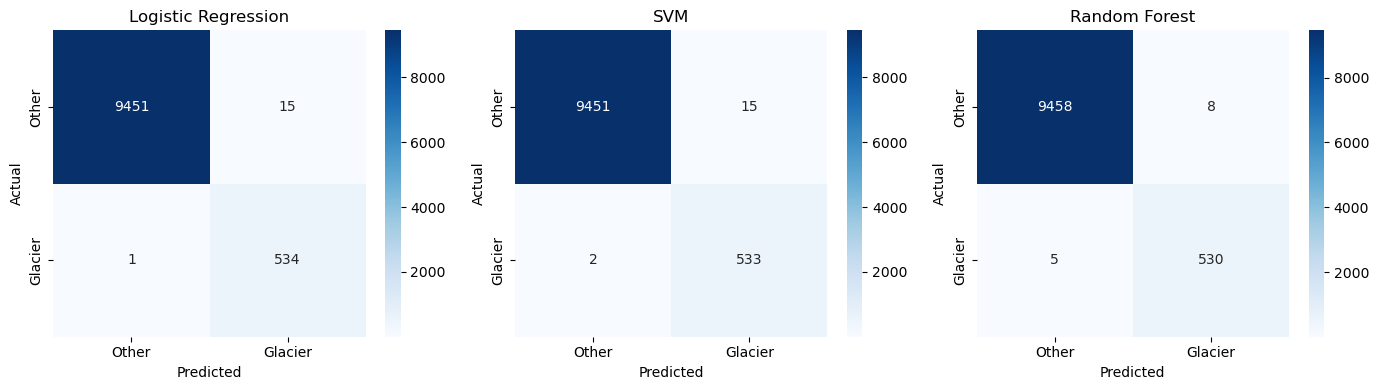

In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(14, 4))

for idx, (name, model) in enumerate(models.items()):
    y_pred = predictions[name]
    cm = confusion_matrix(y_test_binary, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Other', 'Glacier'],
                yticklabels=['Other', 'Glacier'])
    axes[idx].set_title(f'{name}')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

#### **Metrics Comparison Bar Chart**

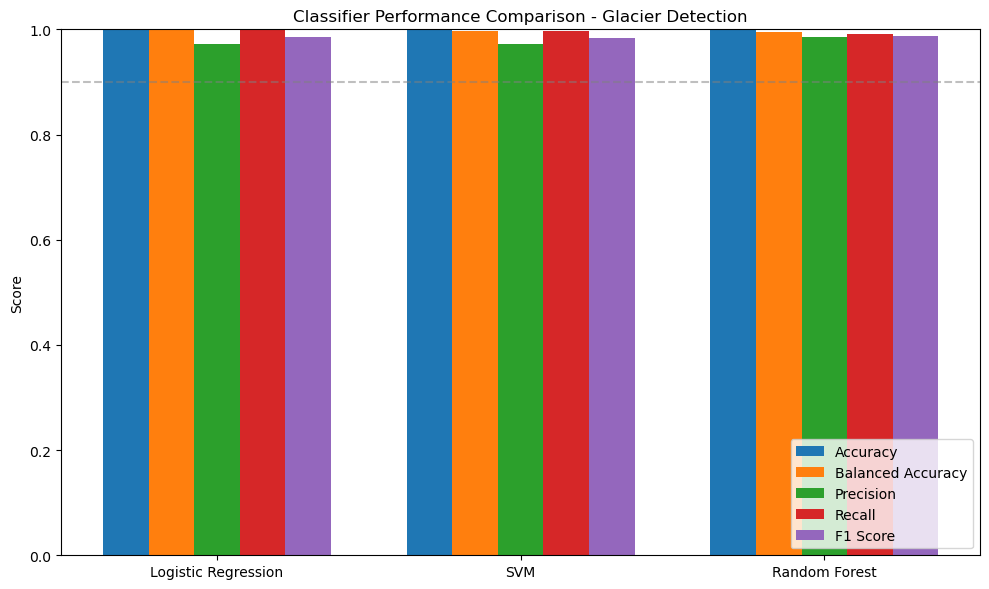

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

metrics = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(models))
width = 0.15

for i, metric in enumerate(metrics):
    values = results_df[metric].values
    bars = ax.bar(x + i * width, values, width, label=metric)

ax.set_ylabel('Score')
ax.set_title('Classifier Performance Comparison - Glacier Detection')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(results_df['Model'])
ax.legend(loc='lower right')
ax.set_ylim(0, 1)
ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

#### **Precision-Recall Curve**

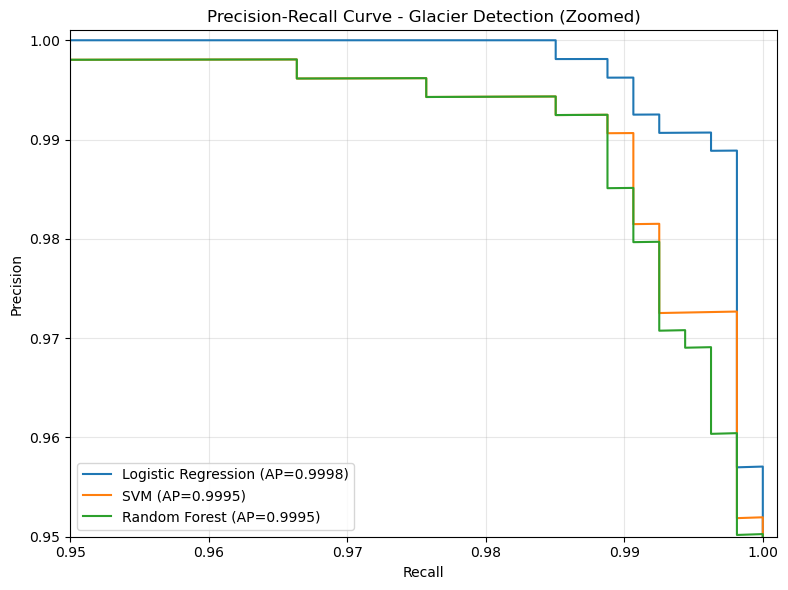

In [28]:
# Zoomed-in version
fig, ax = plt.subplots(figsize=(8, 6))

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test_pca)[:, 1]
    else:
        y_scores = model.decision_function(X_test_pca)
    
    precision, recall, _ = precision_recall_curve(y_test_binary, y_scores)
    ap = average_precision_score(y_test_binary, y_scores)
    ax.plot(recall, precision, label=f'{name} (AP={ap:.4f})')

ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve - Glacier Detection (Zoomed)')
ax.legend(loc='lower left')
ax.set_xlim([0.95, 1.001])  # Zoom into relevant region
ax.set_ylim([0.95, 1.001])
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

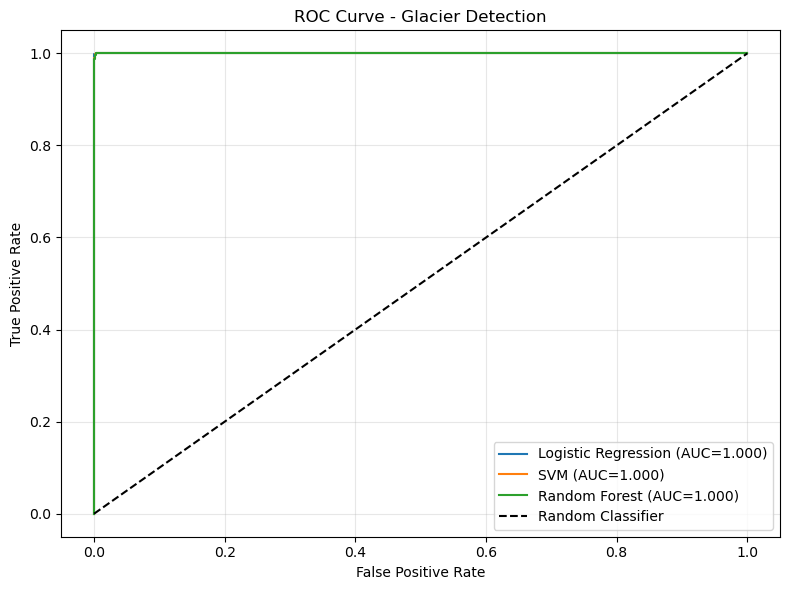

In [ ]:


fig, ax = plt.subplots(figsize=(8, 6))

for name, model in models.items():
    if hasattr(model, 'predict_proba'):
        y_scores = model.predict_proba(X_test_pca)[:, 1]
    else:
        y_scores = model.decision_function(X_test_pca)
    
    fpr, tpr, _ = roc_curve(y_test_binary, y_scores)
    auc = roc_auc_score(y_test_binary, y_scores)
    
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})')

ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve - Glacier Detection')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

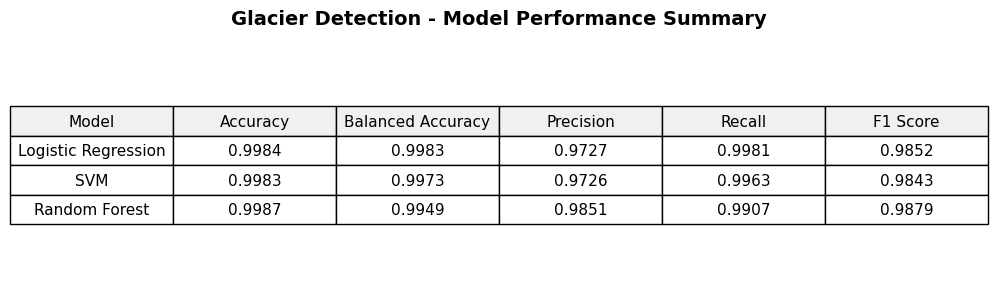

In [ ]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

# Highlight best values
table_data = results_df.round(4)
table = ax.table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc='center',
    loc='center',
    colColours=['#f0f0f0'] * len(table_data.columns)
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.8)

plt.title('Glacier Detection - Model Performance Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('results_table.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# Key findings
print("\nKEY FINDINGS:")
print("-" * 80)
print(f"1. Best Overall Model: Random Forest")
print(f"   - Has fewer false positives than SVM and Logistic Regression (8 vs 15)")
print(f"   - Precision: {results_df.loc[results_df['Model']=='Random Forest', 'Precision'].values[0]:.4f}")
print(f"   - F1 Score: {results_df.loc[results_df['Model']=='Random Forest', 'F1 Score'].values[0]:.4f}")

print(f"\n2. Runner-up: Logistic Regression")
print(f"   - Has fewer false negatives than SVM (1 vs 5)")
print(f"   - Precision: {results_df.loc[results_df['Model']=='Logistic Regression', 'Precision'].values[0]:.4f}")
print(f"   - F1 Score: {results_df.loc[results_df['Model']=='Logistic Regression', 'F1 Score'].values[0]:.4f}")

print(f"\n3. Worst Performer: Support Vector Machine ({results_df.loc[results_df['Model']=='SVM', 'F1 Score'].values[0]:.4f} F1 Score)")


KEY FINDINGS:
--------------------------------------------------------------------------------
1. Best Overall Model: Random Forest
   - Has fewer false positives than SVM and Logistic Regression (8 vs 15)
   - Precision: 0.9851
   - F1 Score: 0.9879

2. Runner-up: Logistic Regression
   - Has fewer false negatives than SVM (1 vs 5)
   - Precision: 0.9727
   - F1 Score: 0.9852

3. Worst Performer: Support Vector Machine (0.9843 F1 Score)



### **Performance Summary**

All three classifiers achieved exceptional performance despite the severe 5.35% class imbalance:

| Model | F1 Score | Precision | Recall | Accuracy |
|-------|----------|-----------|---------|----------|
| **Random Forest** | **98.79%** | 98.51% | 99.07% | 99.87% |
| Logistic Regression | 98.52% | 97.27% | 99.81% | 99.84% |
| SVM | 98.43% | 97.26% | 99.63% | 99.83% |

### **Key Findings**

**Model Performance:**
- **Random Forest emerged as the best performer** with 98.79% F1 score, successfully balancing precision (98.51%) and recall (99.07%)
- All models exceeded 98.4% F1 score, demonstrating robust glacier detection despite severe imbalance
- Logistic Regression achieved the highest recall (99.81%), missing only 1 glacier pixel, though with slightly lower precision
- The minimal performance gap between models (0.36% F1 difference) suggests the spectral signatures provide strong discriminative power

**Handling the Severe Class Imbalance:**
- Class weighting (`class_weight='balanced'`) effectively addressed the 5.35% minority class
- All models achieved >97% precision, meaning few false alarms despite the imbalance
- Recall exceeded 99% across all models, indicating excellent glacier detection with minimal missed pixels

**Dimensionality Reduction using PCA (3 Components):**
- Using only **3 principal components** (99.36% variance) was sufficient for near-perfect binary classification
- This represents a 98.6% reduction in features (from 218 to 3) with no performance degradation
- The efficiency gain enables real-time glacier monitoring applications


**Model recommendation:**
- We recommend **Random Forest** for operational deployment, offering the best F1 score (98.79%) and balanced precision-recall trade-off
- For interpretability needs, Logistic Regression provides comparable performance (98.52% F1) with clear feature weights

---
